<a href="https://colab.research.google.com/github/troncosofranco/ML-Notebooks/blob/main/Mantenimiento_predictivo_de_bombas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Contexto

La planta de galvanizado nos ha proporcionado una dataset con los recopilados de sensores de la bomba de agua de la cuba de anodizado. Según el ingeniero han tenido inconvenientes en el último año con el mantenimiento de la misma. Los materiales son de acero inoxidable y costosos de reemplazar.

Debido a esto, se nos ha solicitado desarrollar la versión preliminar de un algoritmo de IA para implementar futuramente un sistema de mantenimiento predictivo.

#2. Estrategia

##2.1. Análisis Exploratorio de Datos

El análisis exploratorio de datos (EDA) es crucial para comprender la estructura y características de los datos en una planta de galvanizado. Examinar los datos antes de dividirlos en conjuntos de entrenamiento y prueba nos permite identificar patrones y anomalías. Utilizaremos visualizaciones para detectar tendencias y realizar pasos preliminares de preprocesamiento, como la eliminación de columnas vacías.

##2.2. Preprocesamiento
En la etapa de preprocesamiento, nos enfocaremos en preparar los datos para el modelo de aprendizaje automático. Abordaremos los datos faltantes mediante la propagación hacia adelante. Luego, utilizaremos PCA para reducir la dimensionalidad de los datos de los sensores, centrándonos en las características más relevantes.

##2.3. Modelado
Utilizaremos el clustering de KMeans para identificar posibles fallos en los equipos de la planta. KMeans nos permitirá agrupar los datos en clusters, facilitando la detección de patrones anómalos. Compararemos los resultados con métricas de rendimiento como precisión, recall y exactitud. Dado que conocemos las etiquetas de los datos, podremos optimizar la etiquetación mediante permutación, teniendo en cuenta las limitaciones del número de clusters.

##2.4. Comparación de Modelos
Además de KMeans, implementaremos un modelo supervisado como K-Nearest Neighbors (KNN) para comparar los resultados. Evaluaremos ambos modelos y discutiremos otros posibles enfoques para mejorar la detección de fallos en la planta de galvanizado.

##2.5. Conclusiones y Sugerencias Futuras
Finalmente, resumiremos los hallazgos del proyecto, evaluando el desempeño de los modelos y reflexionando sobre posibles mejoras. Discutiremos qué cambios podrían haberse implementado para obtener un mejor rendimiento y cómo estos podrían impactar en la eficiencia operativa de la planta.

#3. Librerias

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# visualización
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing and modeling
import itertools
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Default Parameters
import warnings
warnings.filterwarnings('ignore')
sns.set(style = "whitegrid",font_scale = 1.5)
%matplotlib inline
plt.rcParams['figure.figsize']=[12,8]

#4. Cargar datos

In [ ]:
df = pd.read_csv('sensor.csv')

#5. EDA

Dimensiones del set de datos

In [ ]:
print("El dataset tiene " , df.shape[0],"filas y", df.shape[1], "columnas")

El dataset tiene  220320 filas y 55 columnas


Overview del dataset

In [ ]:
df.head(3)

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.31076,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.31076,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.39757,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL


Información del tipo de dato en las columnas

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

Observamos que hay falta de datos en varios sensores

Cuáles son los tipos de etiquetas que tenemos en los datos para el estado de la bomba?

In [ ]:
df['machine_status'].unique()

array(['NORMAL', 'BROKEN', 'RECOVERING'], dtype=object)

A continuación, describiremos las estadísticas presentadas en los datos sin procesar. Esta es una forma de tener una idea de la distribución de los datos y de buscar valores faltantes.

In [ ]:
df.describe()

,Unnamed: 0,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,220320.000000,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,215213.000000,...,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,143303.000000,204937.000000
mean,110159.500000,2.372221,47.591611,50.867392,43.752481,590.673936,73.396414,13.501537,15.843152,15.200721,...,35.453455,43.879591,42.656877,43.094984,48.018585,44.340903,150.889044,57.119968,183.049260,202.699667
std,63601.049991,0.412227,3.296666,3.666820,2.418887,144.023912,17.298247,2.163736,2.201155,2.037390,...,10.259521,11.044404,11.576355,12.837520,15.641284,10.442437,82.244957,19.143598,65.258650,109.588607
min,0.000000,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,...,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779
25%,55079.750000,2.438831,46.310760,50.390620,42.838539,626.620400,69.976260,13.346350,15.907120,15.183740,...,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,167.534700,179.108800
50%,110159.500000,2.456539,48.133678,51.649300,44.227428,632.638916,75.576790,13.642940,16.167530,15.494790,...,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,193.865700,197.338000
75%,165239.250000,2.499826,49.479160,52.777770,45.312500,637.615723,80.912150,14.539930,16.427950,15.697340,...,36.979164,46.614580,45.138890,44.849540,51.215280,46.585650,208.333300,60.763890,219.907400,216.724500
max,220319.000000,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,24.348960,...,374.218800,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,1000.000000


##Missing values

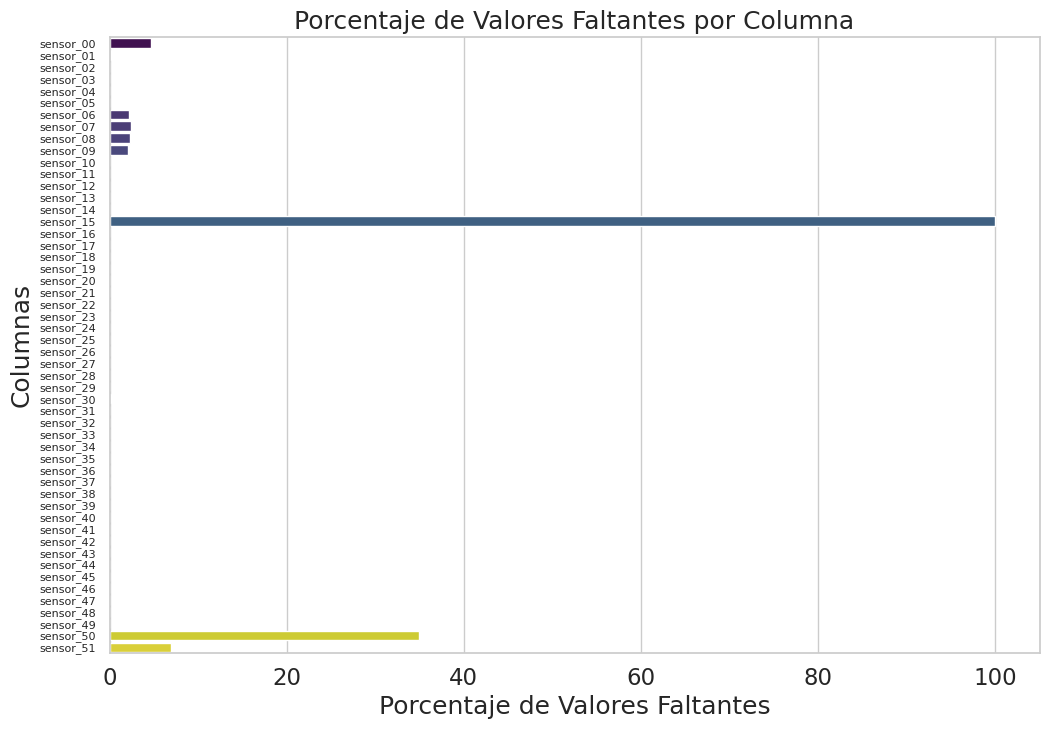

In [ ]:
# Calcular el porcentaje de valores faltantes por columna
missing_percent = df.isnull().mean() * 100

# Filtrar columnas con valores faltantes
missing_percent = missing_percent[missing_percent > 0]

# Crear un gráfico de barras horizontal
plt.figure(figsize=(12, 8))
sns.barplot(x=missing_percent.values, y=missing_percent.index, palette='viridis', orient='h')
plt.xlabel('Porcentaje de Valores Faltantes')
plt.ylabel('Columnas')
plt.title('Porcentaje de Valores Faltantes por Columna')

# Reducir el tamaño de las letras de los nombres de las columnas
plt.yticks(fontsize=8)  # Ajusta el valor según sea necesario

plt.show()

- Podemos observar que múltiples columnnas tienen datos faltantes.
- Definimos en un vector la lista de columnas que deseamos remover.
- También removemos Unnamed:0 columna que es el index duplicado.

1. A qué se deben está falta de datos?
2. Estos datos pueden ser completados?
3. Los datos faltantes son importantes?
4. Cómo se pueden recopilar esos datos?
5. Cuál fue la causa de la falta de esos datos?

In [ ]:
# Especificar las columnas a eliminar
columns_to_drop = ['Unnamed: 0', 'sensor_00','sensor_15','sensor_50', 'sensor_51']

# Eliminar las columnas específicas in-place
df.drop(columns=columns_to_drop, inplace=True)

Determinamos nuevamente la magnitud de datos faltantes

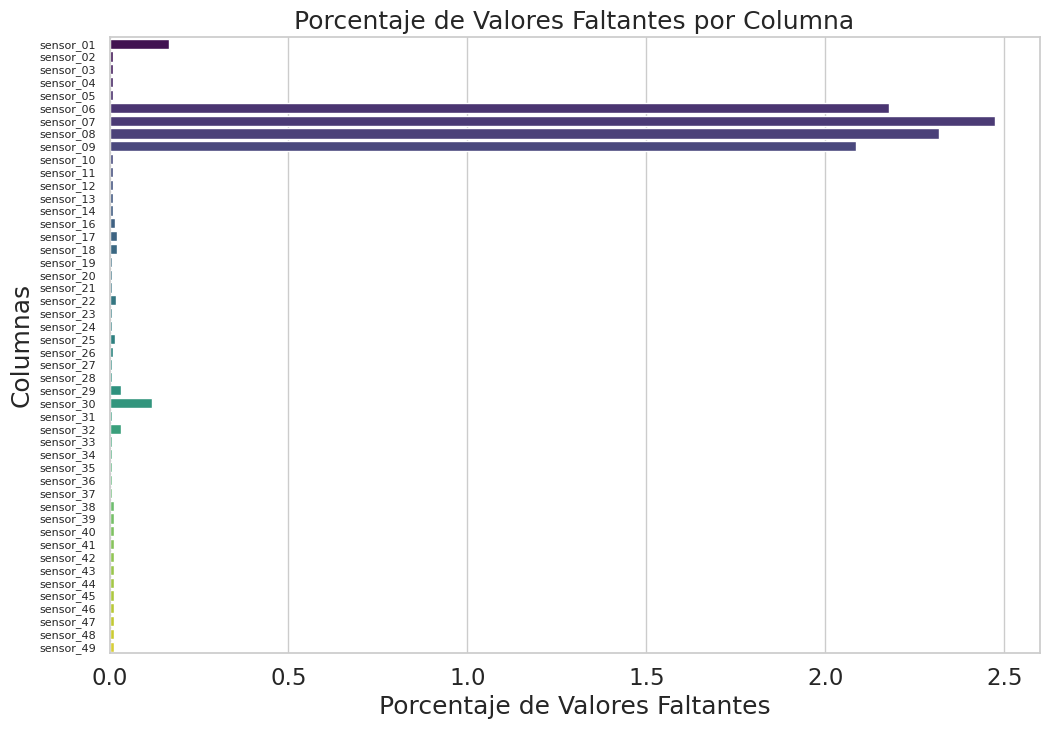

In [ ]:
# Calcular el porcentaje de valores faltantes por columna
missing_percent = df.isnull().mean() * 100

# Filtrar columnas con valores faltantes
missing_percent = missing_percent[missing_percent > 0]

# Crear un gráfico de barras horizontal
plt.figure(figsize=(12, 8))
sns.barplot(x=missing_percent.values, y=missing_percent.index, palette='viridis', orient='h')
plt.xlabel('Porcentaje de Valores Faltantes')
plt.ylabel('Columnas')
plt.title('Porcentaje de Valores Faltantes por Columna')

# Reducir el tamaño de las letras de los nombres de las columnas
plt.yticks(fontsize=8)  # Ajusta el valor según sea necesario

plt.show()

- Aún hay columnas con datos faltantes, podemos realizar un heatmap.
- Las columnas del DataFrame aparezcan como filas en el mapa de calor, facilitando la visualización cuando hay muchas columnas.

El mapa de calor te permite identificar rápidamente patrones de datos faltantes. Por ejemplo:

- Filas Horizontales Completamente Azules: Indican que una columna específica tiene valores faltantes en todas las filas.
- Patrones Horizontales Parciales: Indican que algunos valores faltan en una columna específica.
- Áreas sin Color (o de Color Claro): Indican la presencia de datos no faltantes.

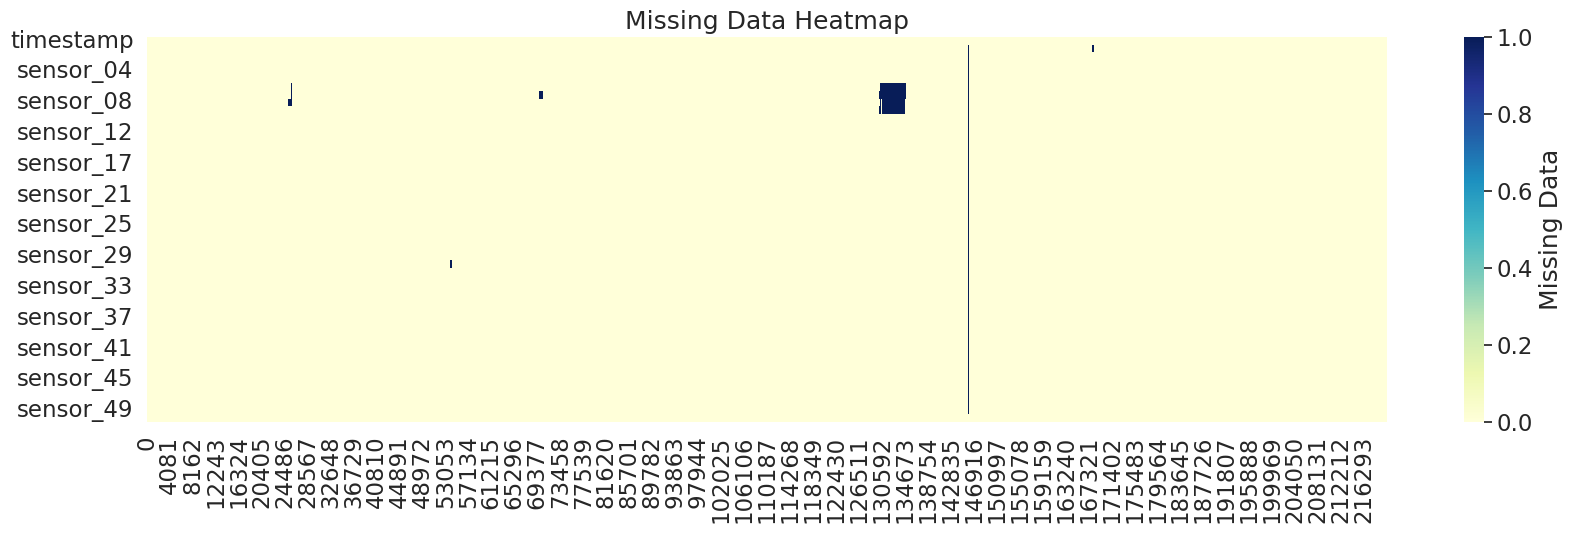

In [ ]:
plt.figure(figsize=(20,5))
sns.heatmap(df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.title('Missing Data Heatmap')
plt.show();

1. Observación: Hay una sección significativa donde varios sensores no registraron datos simultáneamente. Esto puede deberse a factores como condiciones climáticas, fallos eléctricos, mantenimiento, entre otros.
2. Opciones para los Datos:
Eliminar filas con valores faltantes, ya que cada columna tiene aproximadamente un 2% o menos de datos faltantes.
3. División 60/40: Dividiremos los datos en un 60% para entrenamiento y un 40% para prueba.
4. Datos de Serie Temporal: Usaremos el último 40% del conjunto de datos como datos de prueba, para simular la predicción en datos futuros.
5. Razón para la División: Aunque normalmente se usa alrededor del 20% para pruebas, en este caso, se usará un 30% debido a la cantidad de datos disponibles y la necesidad de prever fallos futuros.
6. Fallos en los Datos:
Hay 7 fallos en el conjunto de datos.
Al menos 2 de estos fallos se incluirán en el conjunto de prueba para evaluar la capacidad del modelo para detectarlos.

Dividimos el set de datos

In [ ]:
# Dividir datos en 60% entrenamiento y 40% prueba, usando el último 40% como conjunto de prueba
split_index = int(len(df) * 0.4)
train = df.iloc[:split_index]
test = df.iloc[split_index:]

In [ ]:
test[test['machine_status']=='BROKEN']

,timestamp,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,machine_status
128040,2018-06-28 22:00:00,40.190970,45.22569,40.190971,201.368622,0.00000,11.335360,15.270540,15.183740,15.118630,...,23.177082,24.73958,32.29166,28.06713,28.067129,29.513889,29.224537,29.224537,29.513889,BROKEN
141131,2018-07-08 00:11:00,45.138890,52.90799,45.355900,500.000000,1.40131,0.028935,0.036169,0.036169,0.007234,...,35.416660,32.81250,36.19791,37.32639,35.300930,38.194440,43.402780,99.537030,44.849540,BROKEN
166440,2018-07-25 14:00:00,45.833332,52.99479,43.880210,420.503448,72.52040,14.185470,16.247110,15.697340,15.053530,...,35.416660,36.45833,51.30208,52.10200,52.662040,67.129630,43.981480,230.324100,69.733800,BROKEN


En el test dataset tenemos 3 casos de fallos para validar la predicción de nuestro modelo una vez entrenado.

#6. Visualización

Una vez que separamos nuestro set de entrenamiento implementamos visualizaciones para obtener insights.

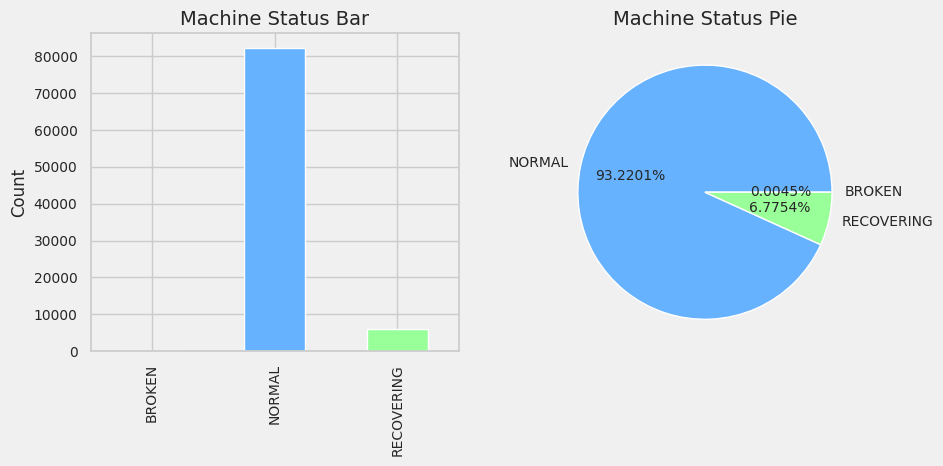

In [ ]:
# Crear una figura con dos subgráficos
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# Agrupar por 'machine_status' y contar el tamaño de cada grupo
status_counts = train.groupby('machine_status').size()

# Definir colores personalizados
bar_colors = ['#FF9999', '#66B2FF', '#99FF99']  # Colores personalizados para el gráfico de barras
pie_colors = ['#FF9999', '#66B2FF', '#99FF99']  # Colores personalizados para el gráfico de pastel
background_color = '#F0F0F0'  # Color de fondo para los gráficos

# Establecer el color de fondo
fig.patch.set_facecolor(background_color)

# Crear gráfico de barras
status_counts.plot(kind='bar', ax=ax1, color=bar_colors)
ax1.set_title('Machine Status Bar', fontsize=14)
ax1.set_xlabel('', fontsize=12)  # Eliminar etiqueta del eje X
ax1.set_ylabel('Count', fontsize=12)  # Etiqueta del eje Y
ax1.tick_params(axis='both', which='major', labelsize=10)  # Tamaño de fuente de las etiquetas de los ejes
ax1.set_facecolor(background_color)  # Color de fondo del gráfico de barras

# Crear gráfico de pastel
status_counts.plot(kind='pie', ax=ax2, autopct='%.4f%%', colors=pie_colors, textprops={'fontsize': 10})
ax2.set_title('Machine Status Pie', fontsize=14)
ax2.set_ylabel('', fontsize=12)  # Eliminar etiqueta del eje Y
ax2.set_facecolor(background_color)  # Color de fondo del gráfico de pastel

# Ajustar el diseño y mostrar los gráficos
plt.tight_layout()
plt.show()

Es posible observar que la mayoría de los registros se corresponden con el status NORMAL (la bomba funciona normalmente la mayor parte del tiempo). Luego observamos la RECUPERACIÓN como el siguiente grupo, ya que la máquina se estropea y luego tarda un poco en recuperarse. Finalmente, solo el 0.0045% de los datos están en estado Broken.

##Visualización temporal

Puntos de fallos

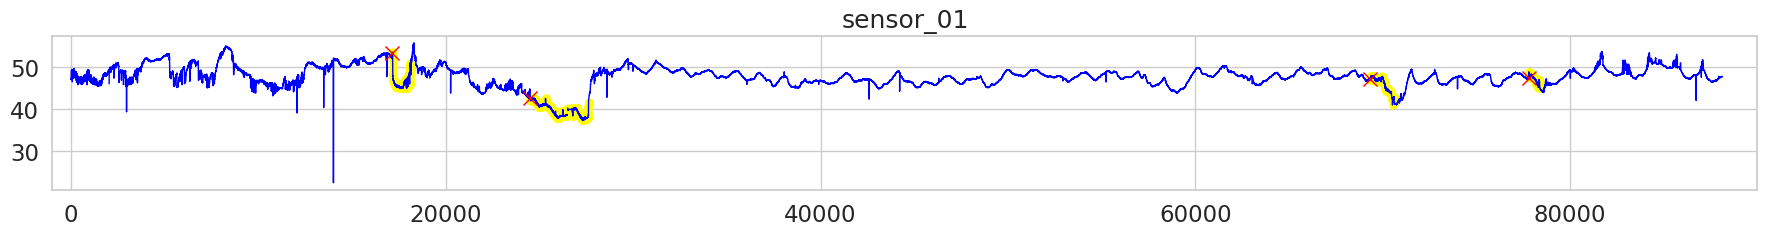

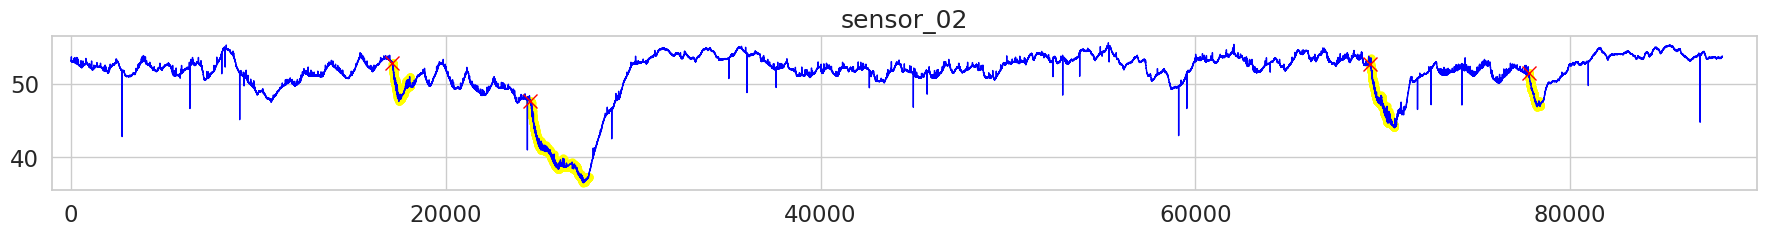

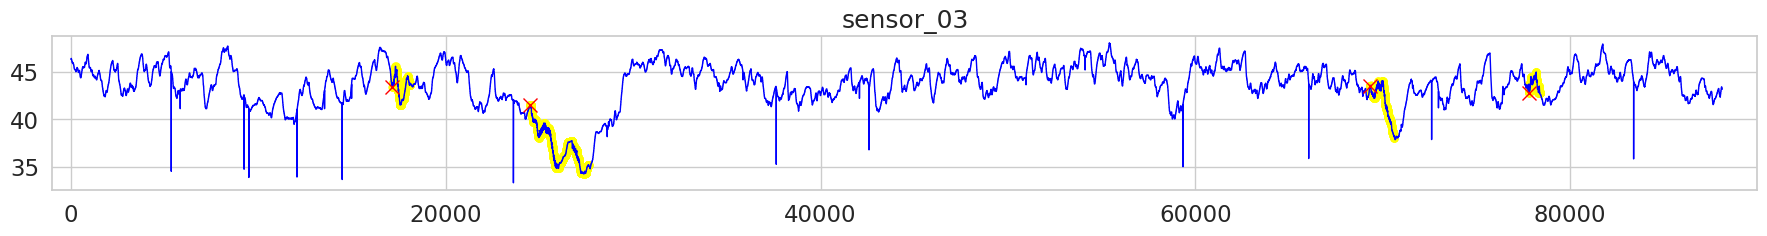

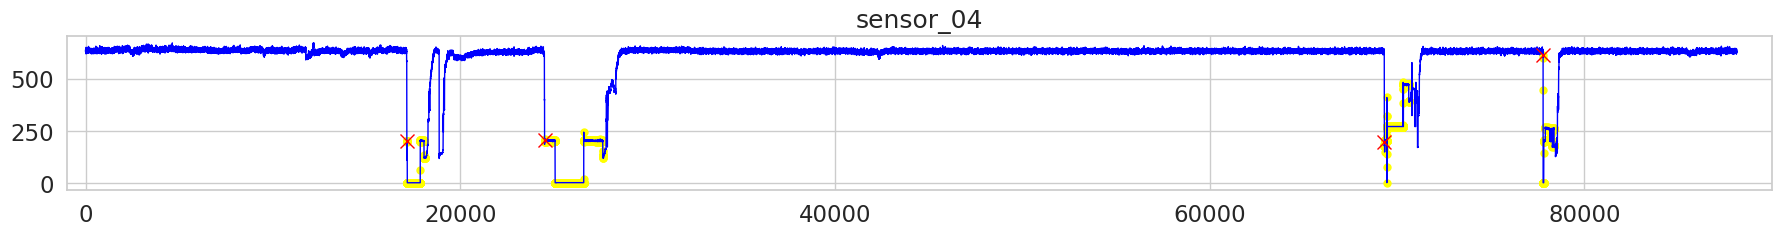

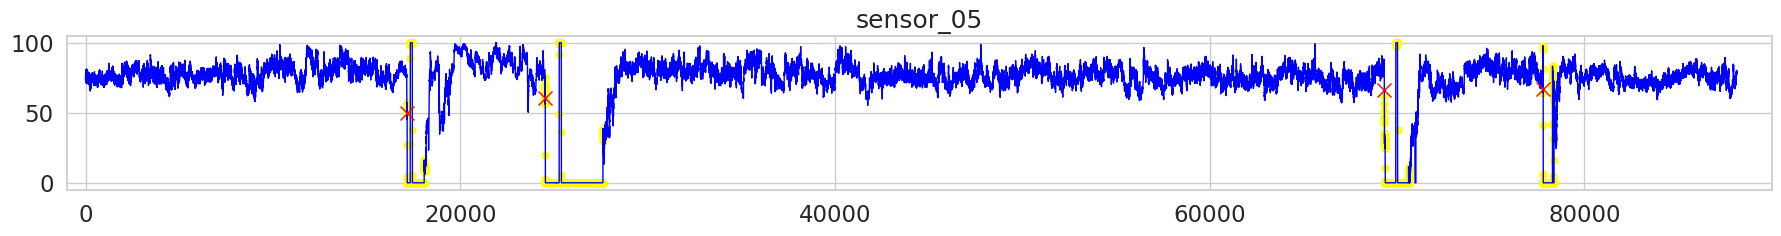

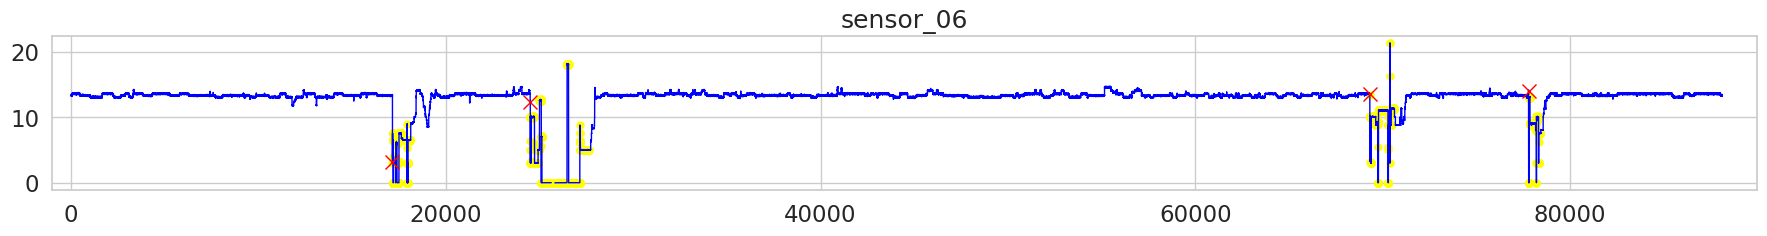

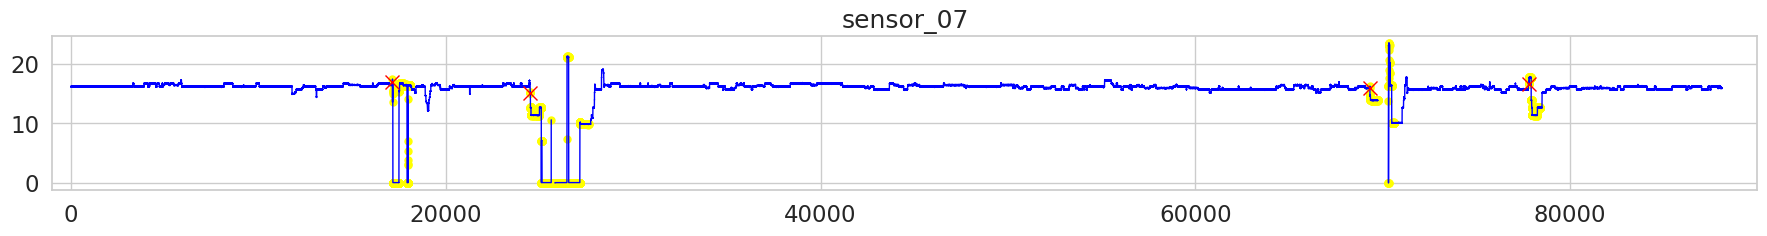

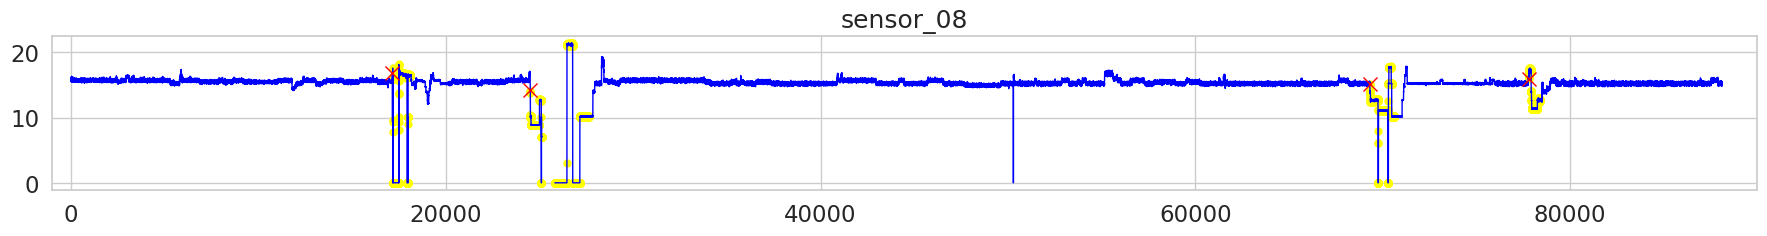

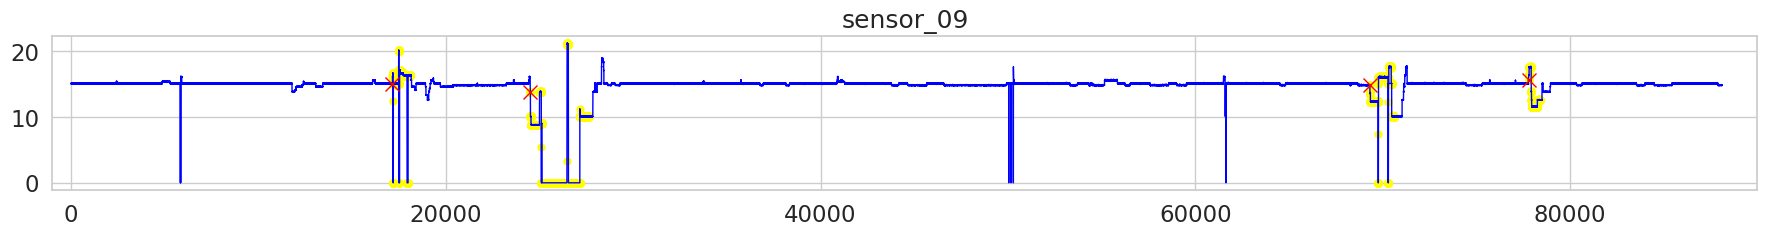

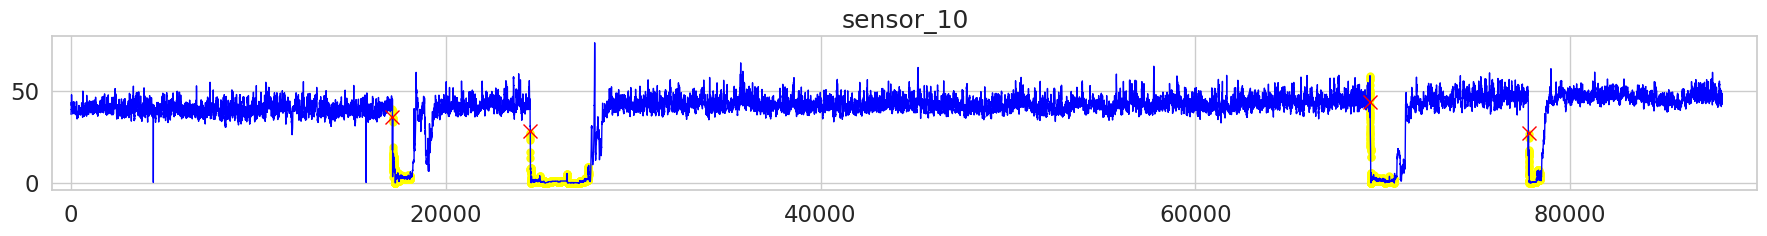

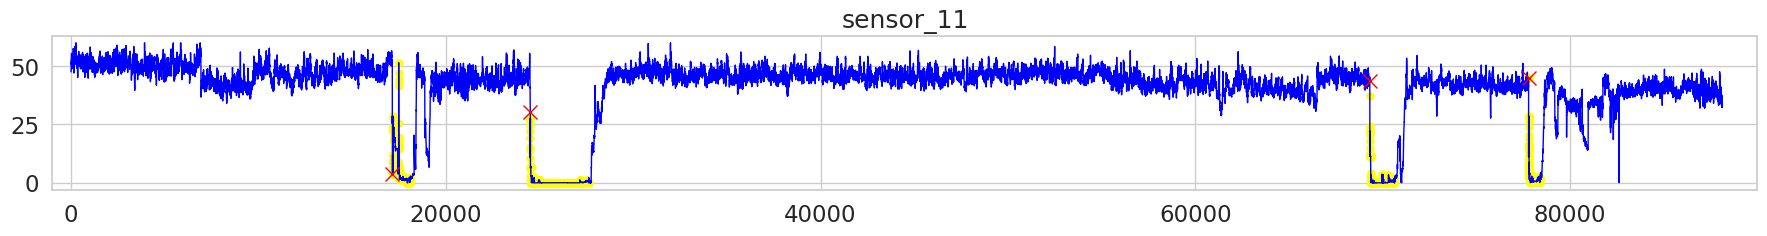

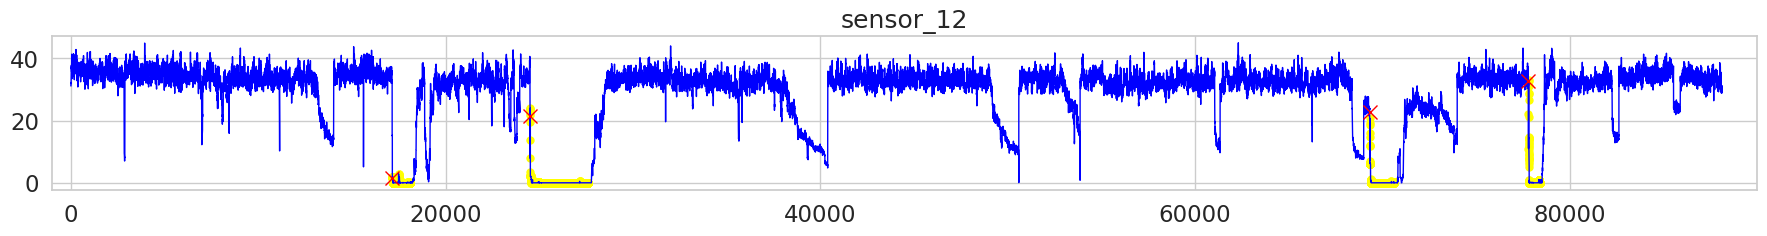

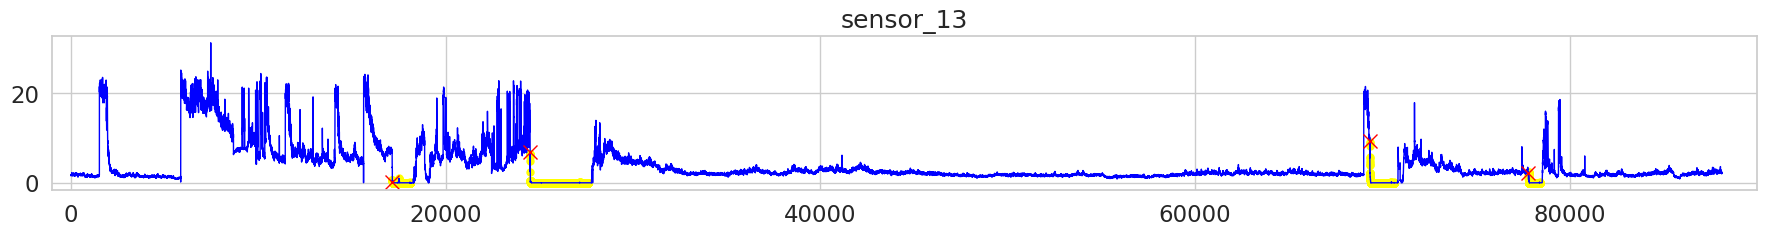

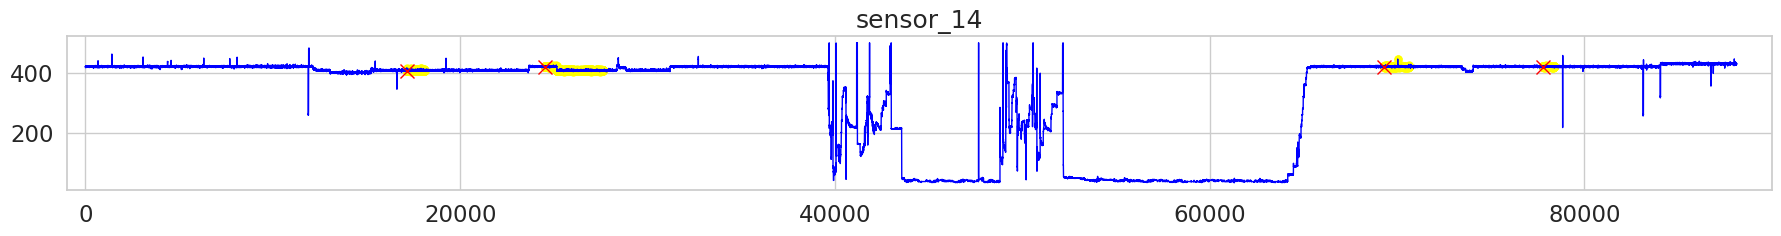

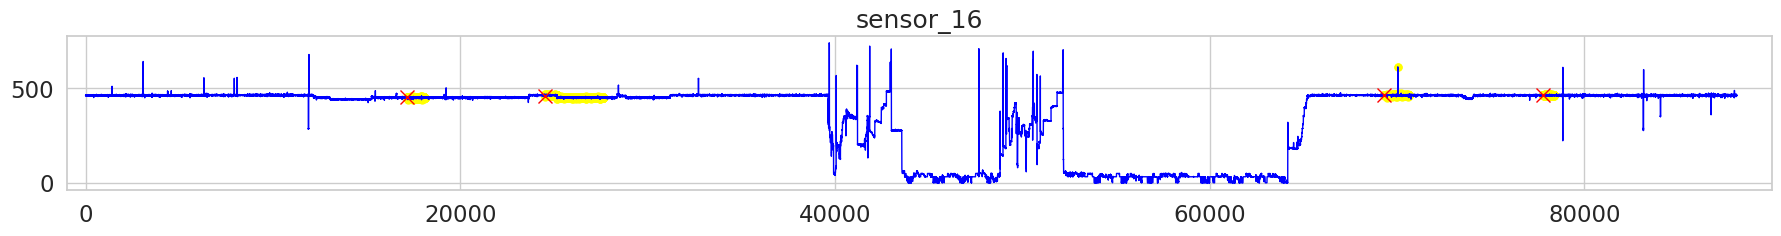

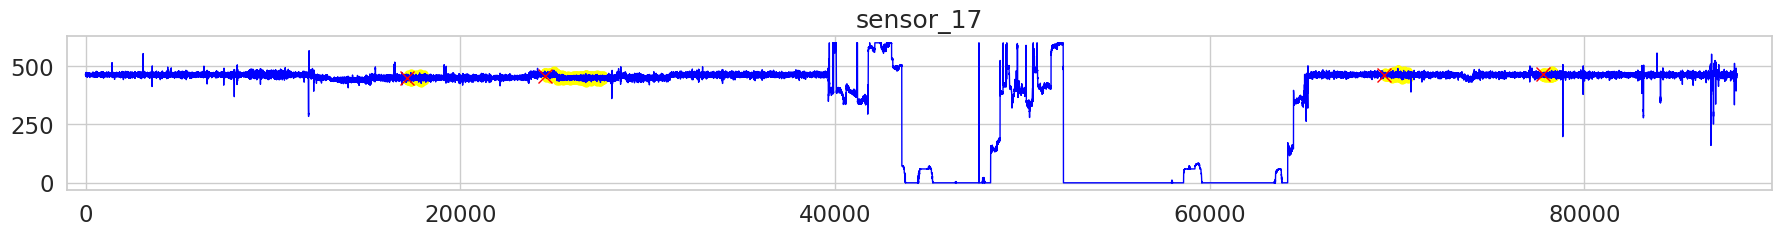

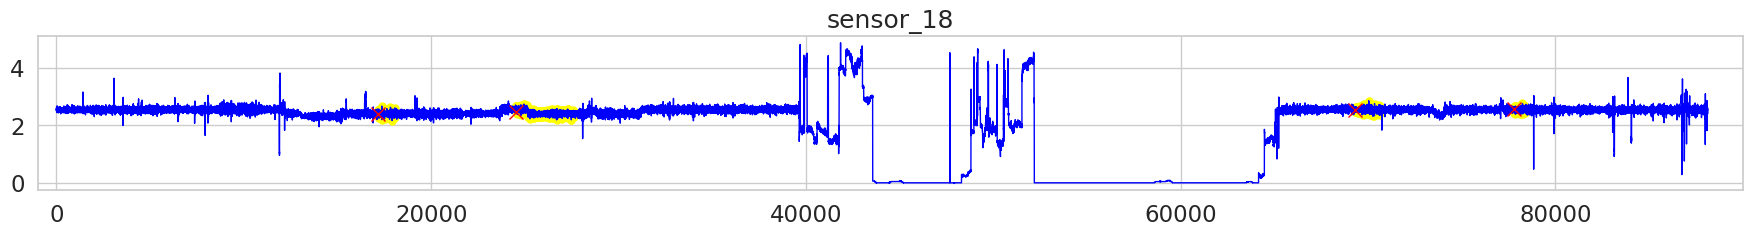

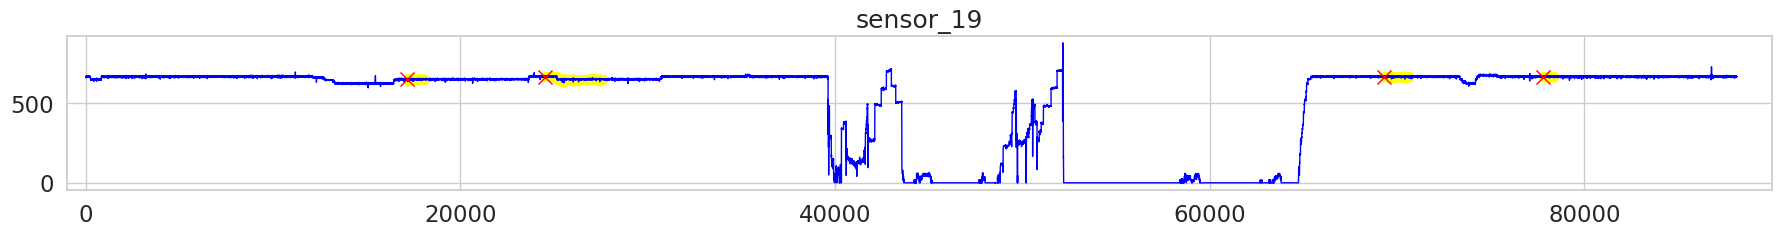

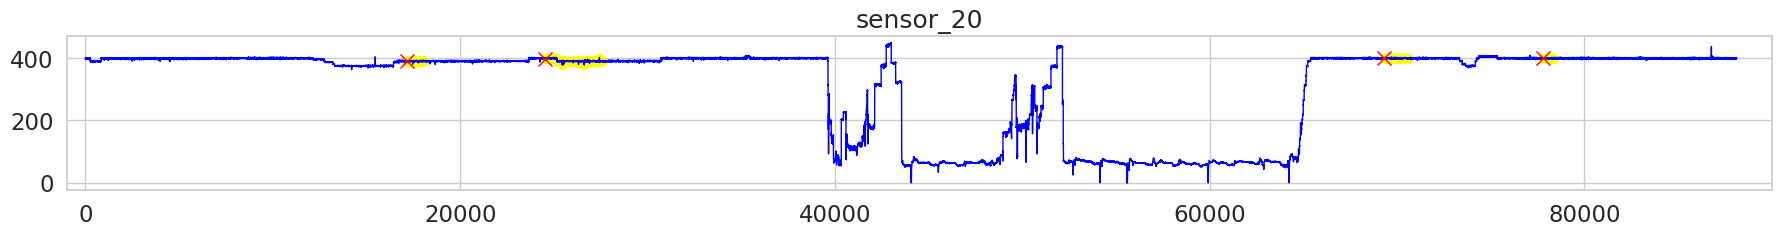

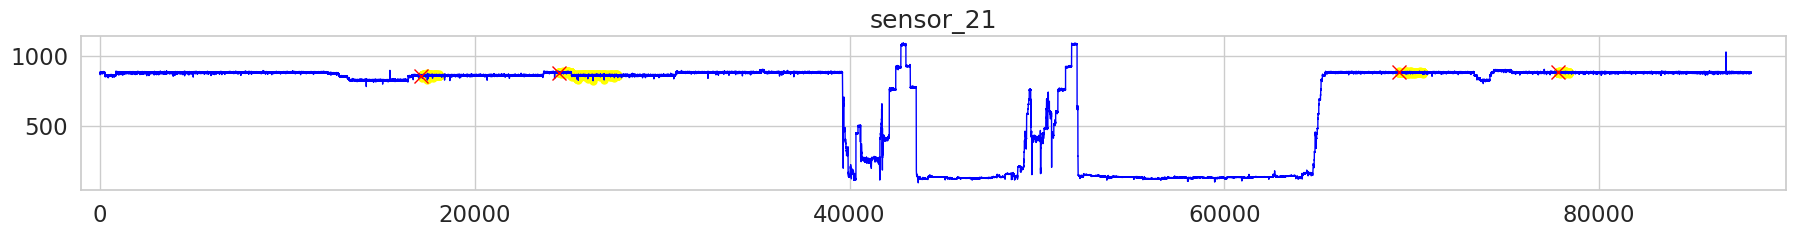

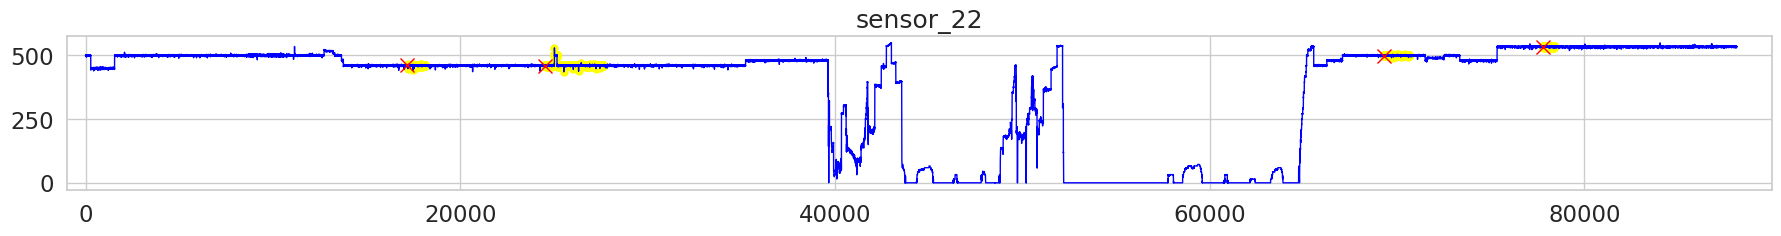

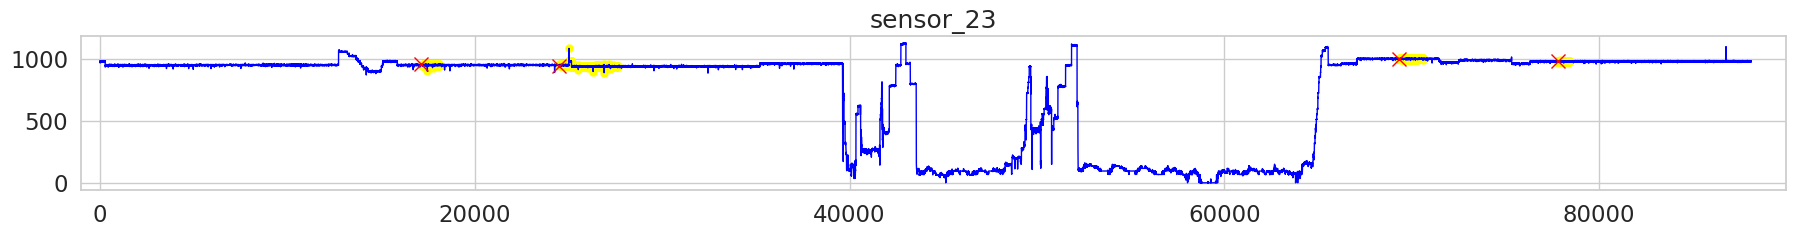

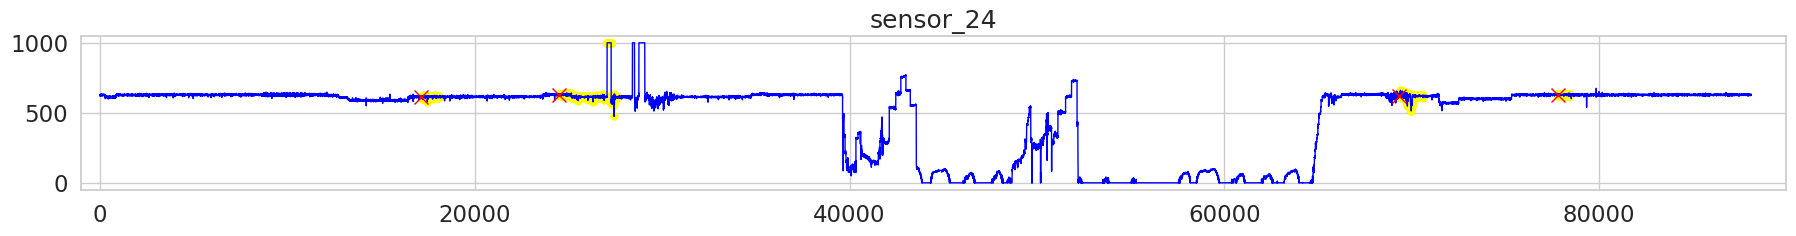

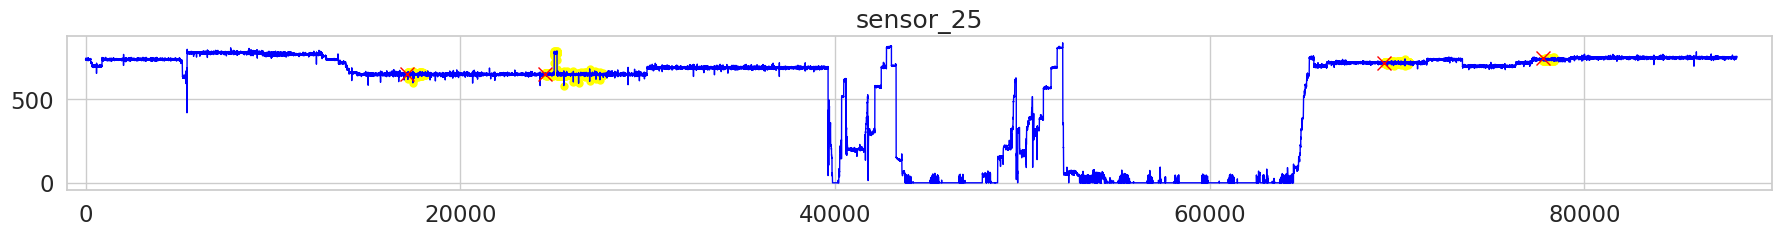

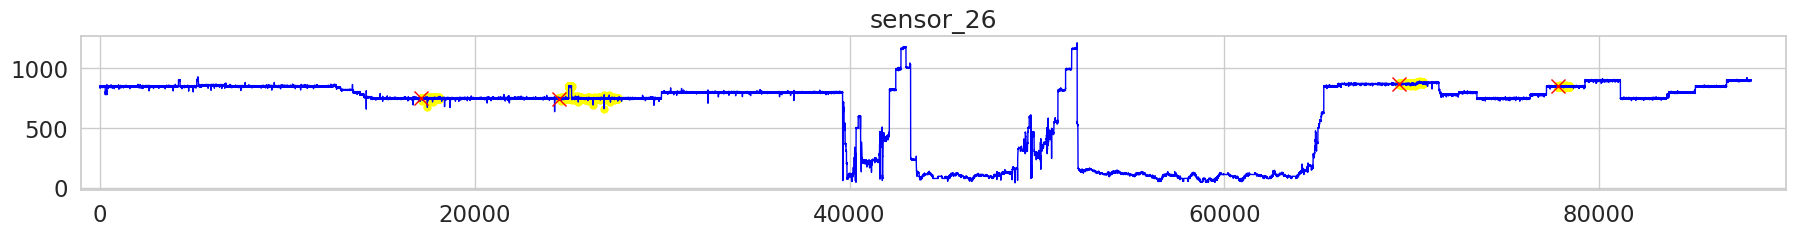

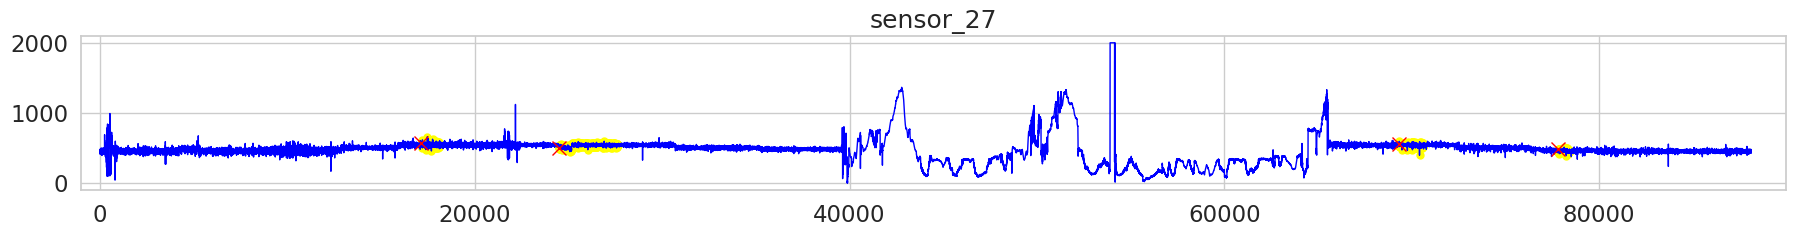

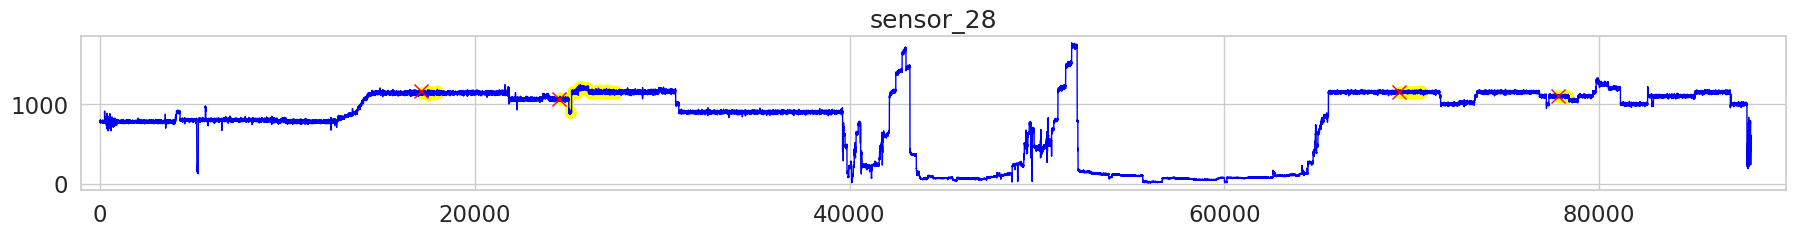

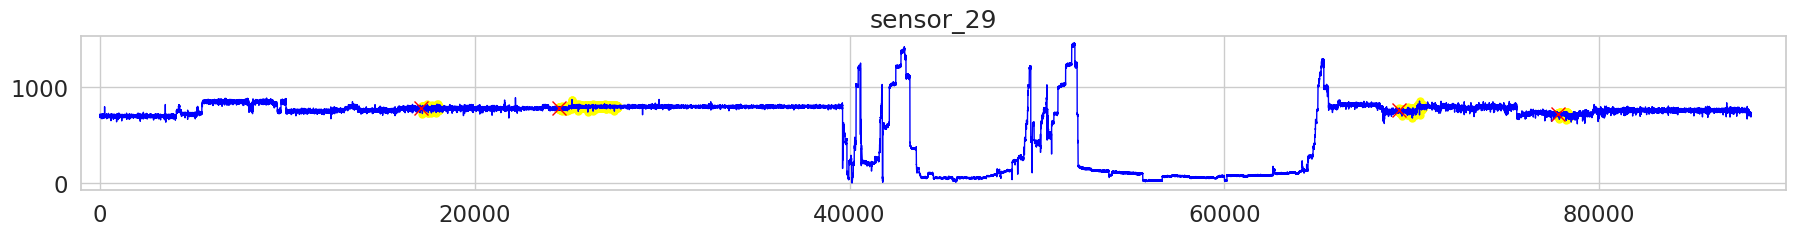

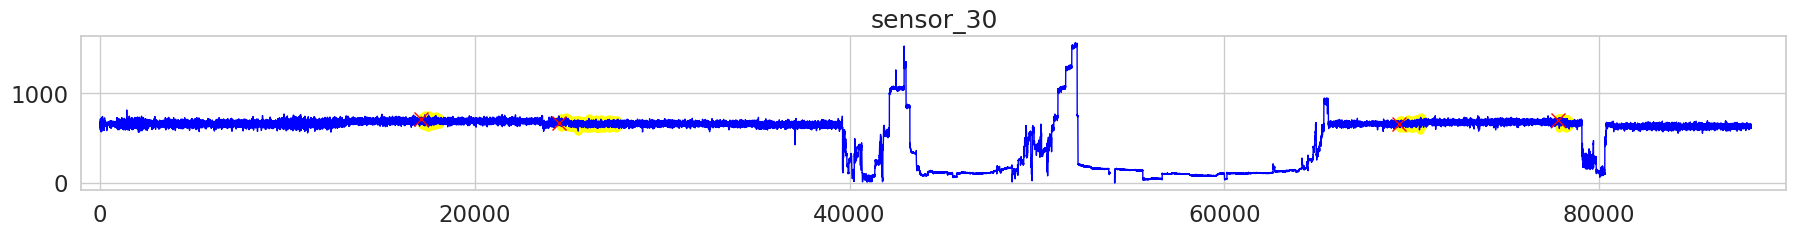

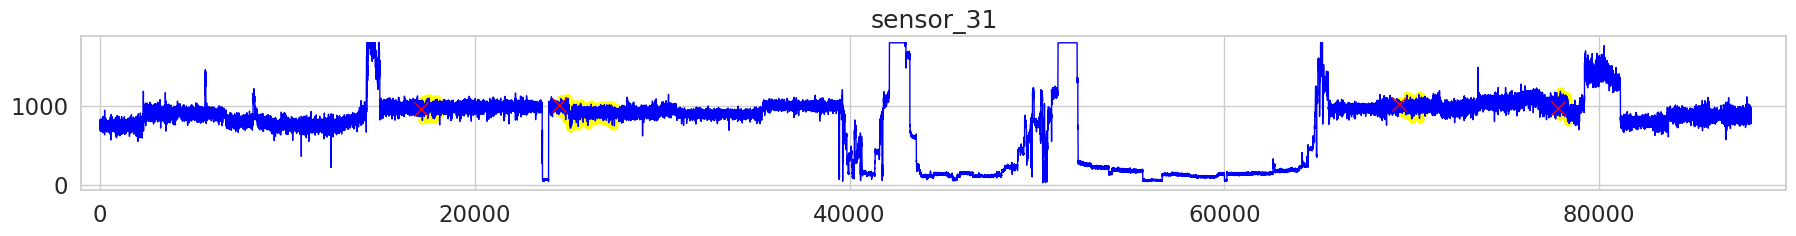

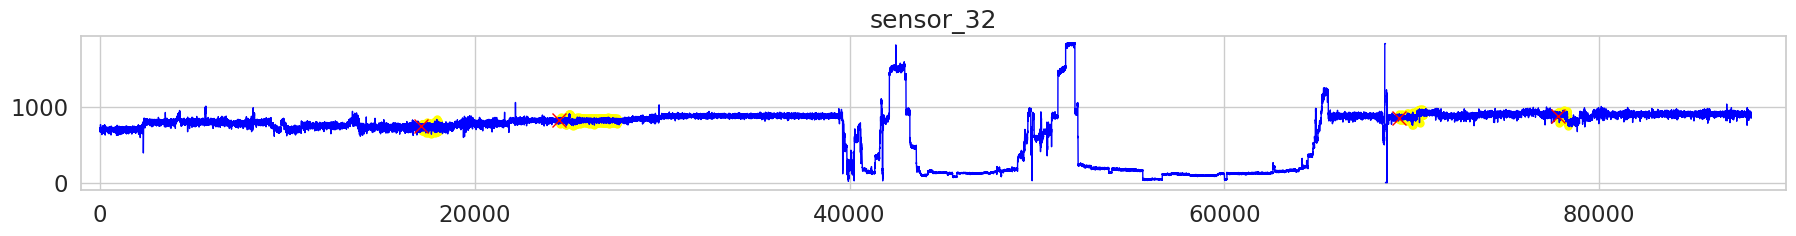

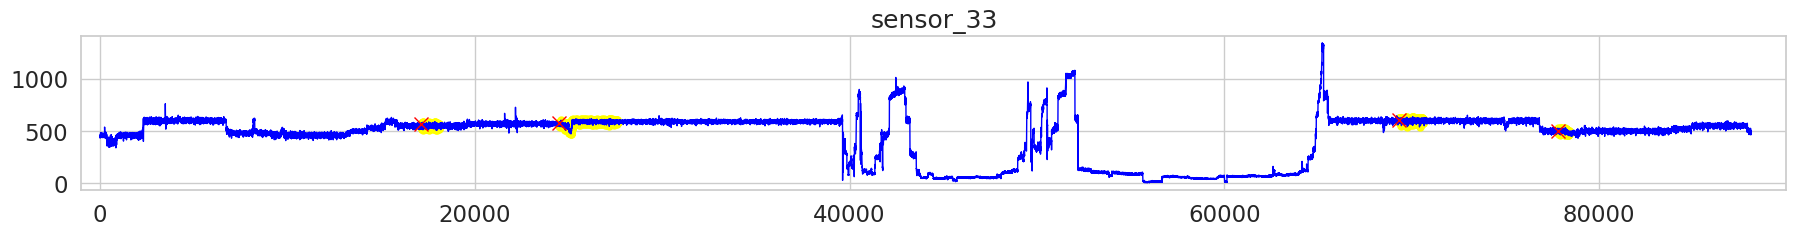

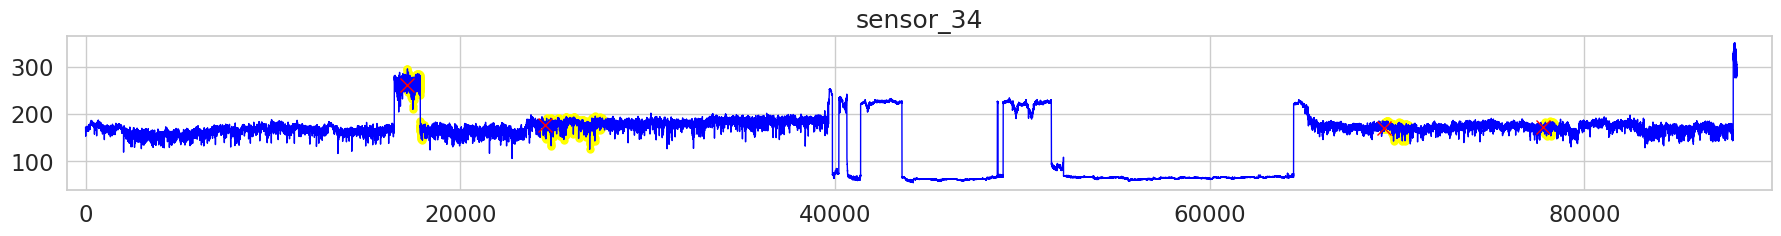

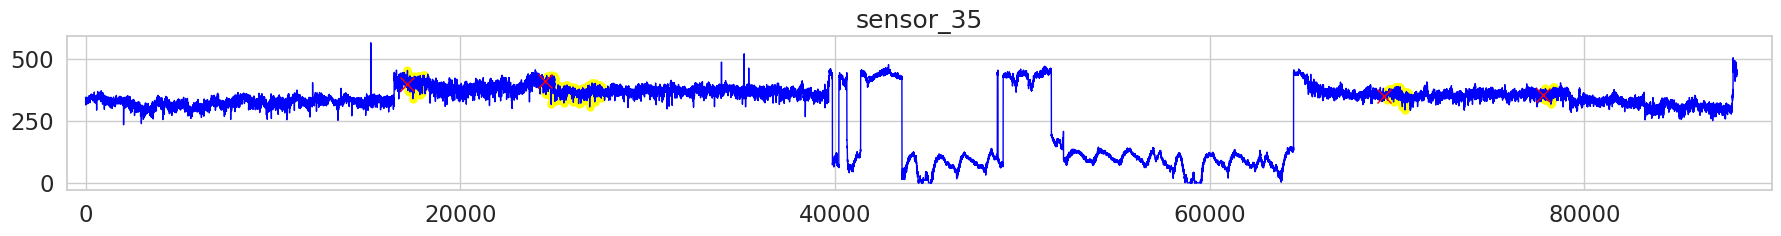

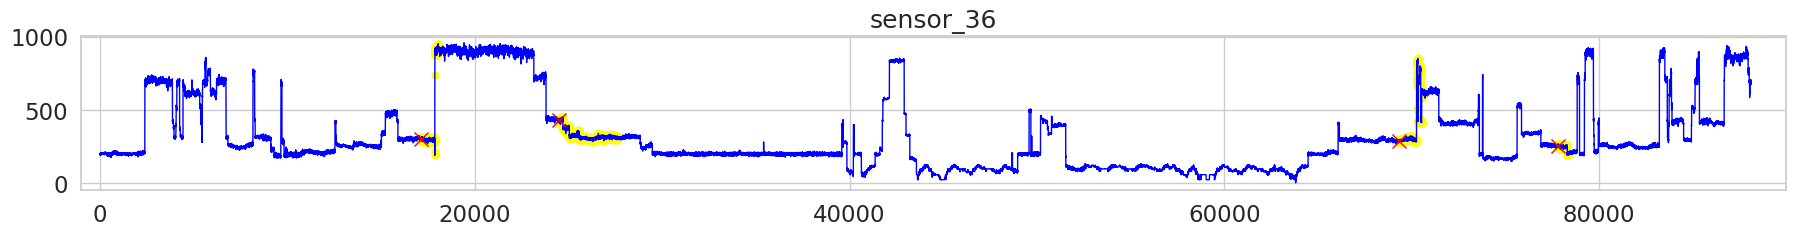

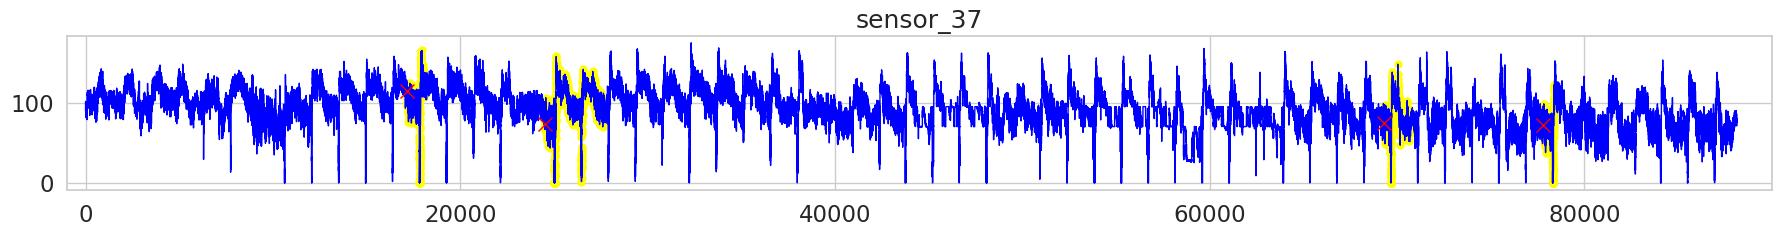

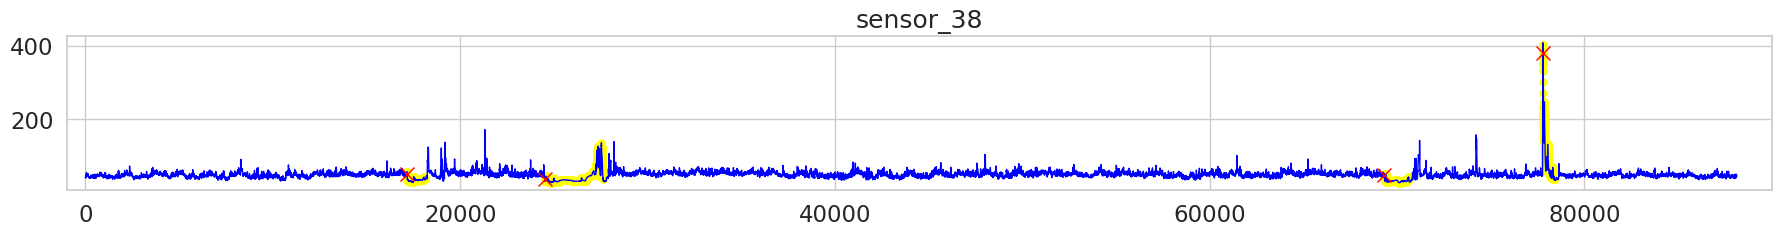

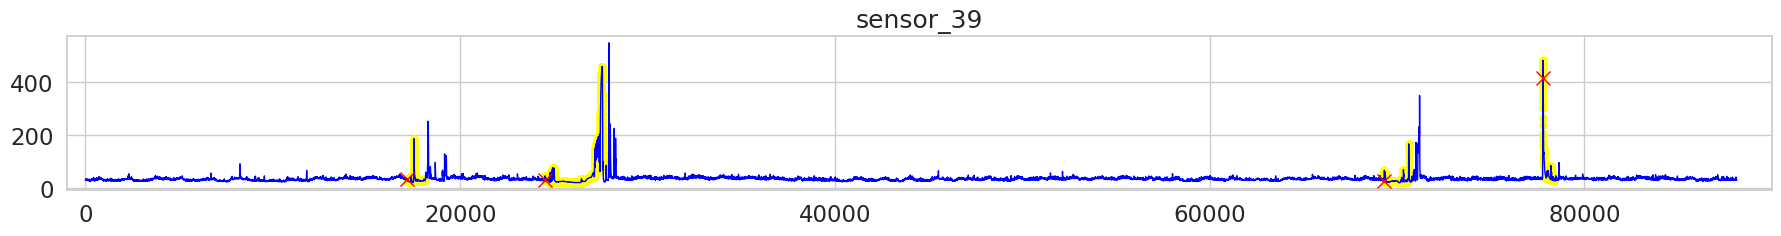

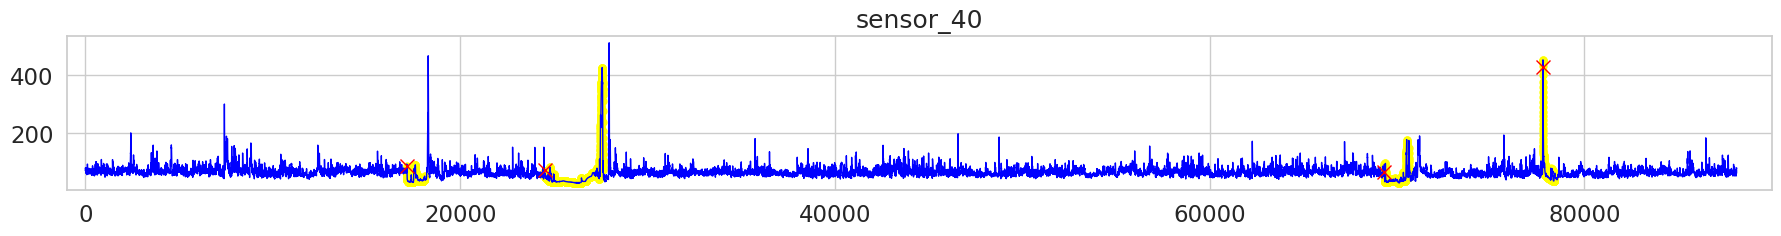

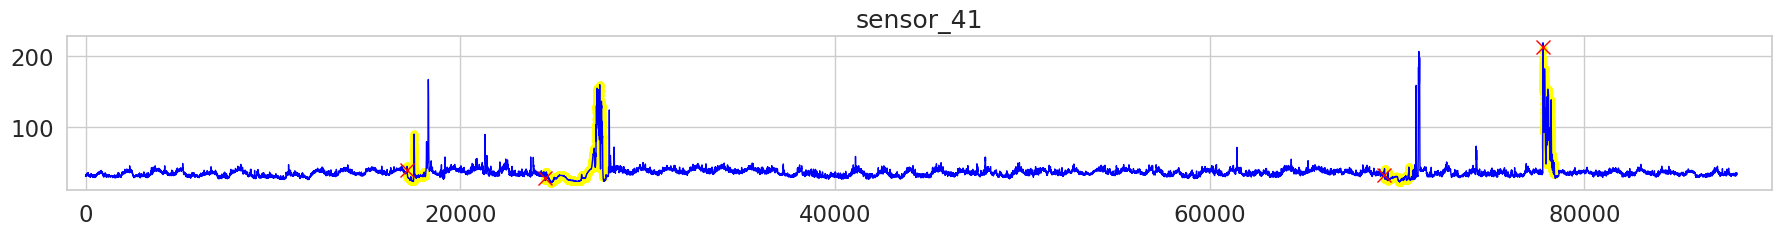

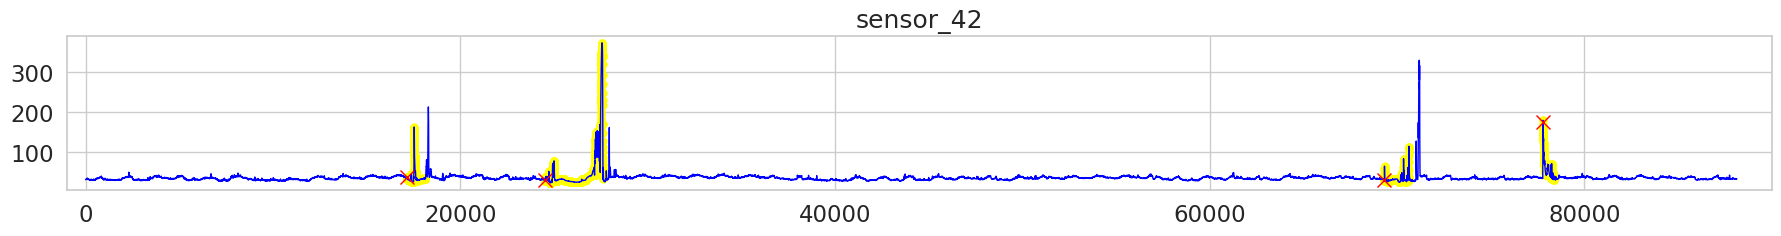

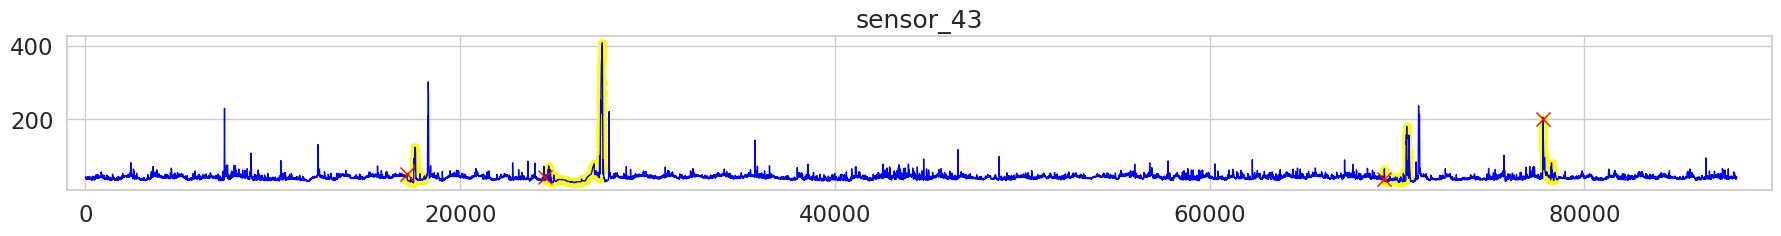

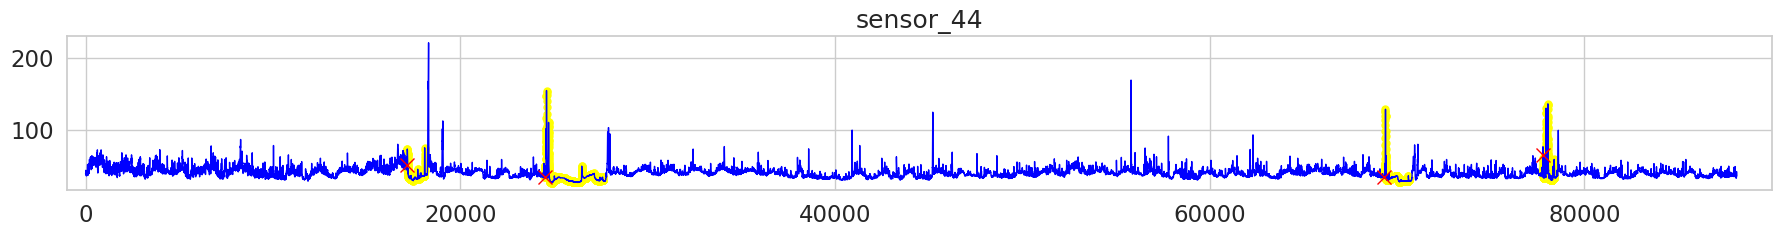

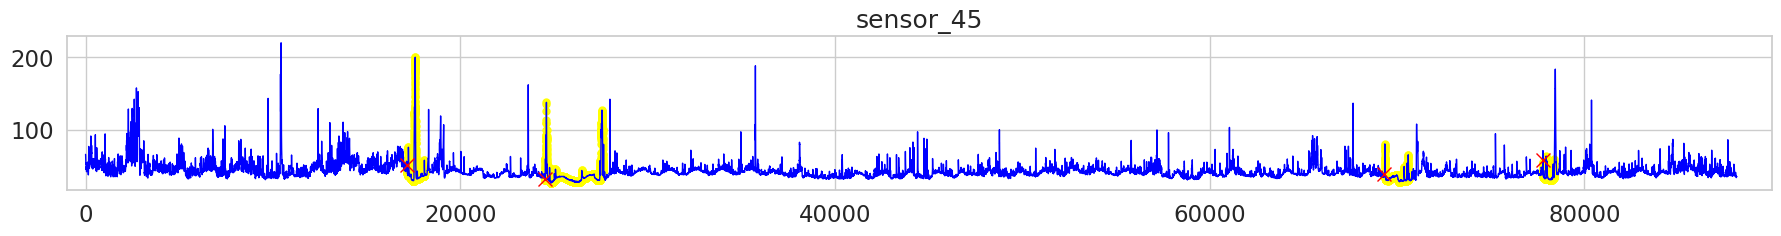

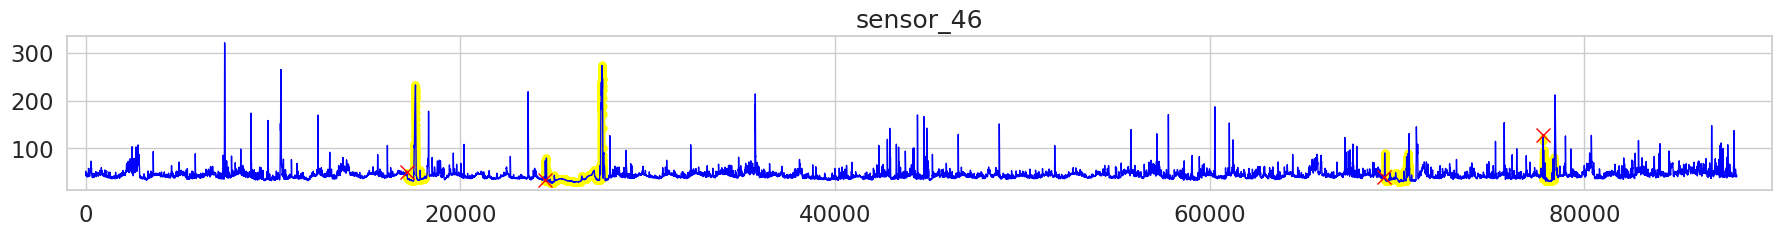

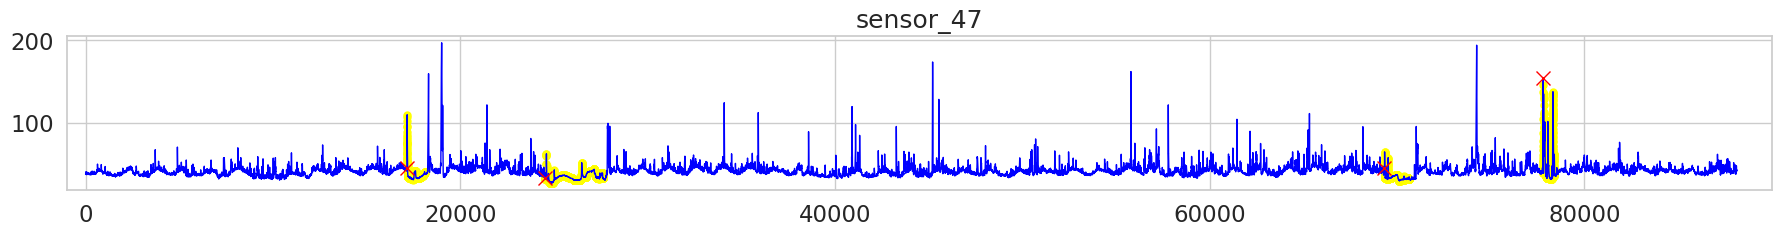

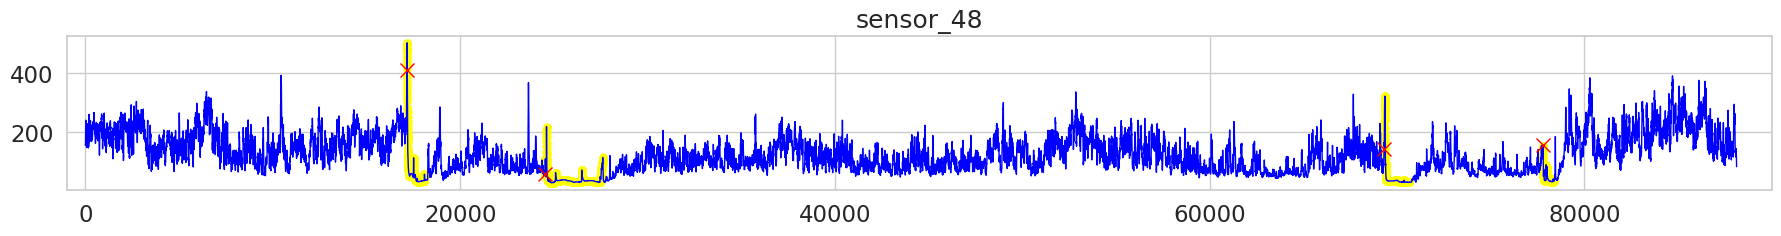

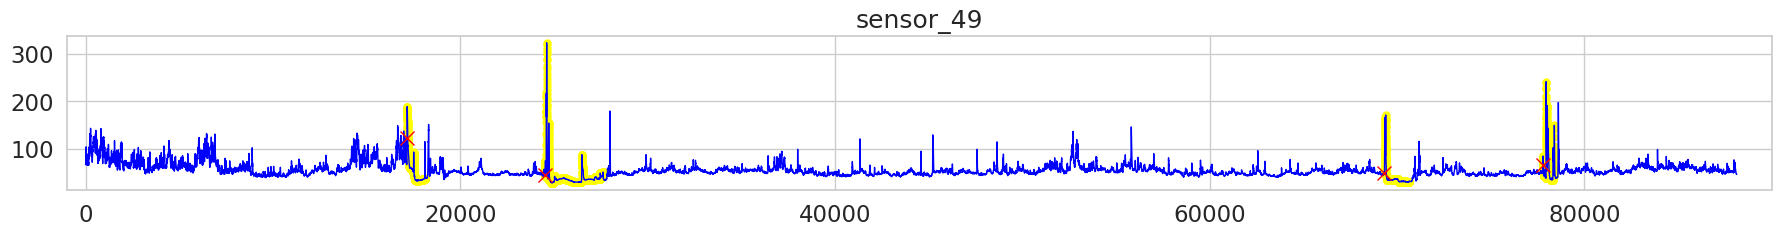

In [ ]:
# Definir los colores y tamaños de los marcadores
recovery_color = 'yellow'
recovery_marker_size = 5
broken_color = 'red'
broken_marker_size = 10
line_color = 'blue'

# Obtenemos las columnas y filas según el tipo de status
sensor_cols = train.iloc[:,1:49]
broken_rows = train[train['machine_status']=='BROKEN']
recovery_rows = train[train['machine_status']=='RECOVERING']
normal_rows = train[train['machine_status']=='NORMAL']
machine_status_col = train['machine_status']

# Ajustar el tamaño de la figura y el estilo de los gráficos
for sensor in sensor_cols:
    plt.figure(figsize=(22, 2))

    # Plotear datos de recuperación
    plt.plot(recovery_rows[sensor], linestyle='none', marker='o', color=recovery_color, markersize=recovery_marker_size)

    # Plotear datos completos
    plt.plot(train[sensor], color=line_color, linewidth=1)

    # Plotear datos rotos
    plt.plot(broken_rows[sensor], linestyle='none', marker='x', color=broken_color, markersize=broken_marker_size)

    # Título del gráfico
    plt.title(sensor)

    # Ajustar los límites del eje X si es necesario
    plt.xlim((-1000, 90000))

    # Mostrar el gráfico
    plt.show()

Podemos hacer las siguientes observaciones:
1. Las gráficas en los sensores tienen grandes variaciones alrededor del tiempo del marcador x 40000-65000.
2. Algunos sensores caen a valores muy bajos, otros aumentan, mientras que otros (que normalmente son constantes) vibran mucho. Vemos que en estos tiempos la máquina ha fallado y se está recuperando al menos una vez.
3. Identificación de Picos: Notamos que las fallas (marcadas con una 'X' roja) tienden a ocurrir después de un período de actividad elevada en los sensores, que se puede identificar como picos en las lecturas de los sensores.
4. Patrón de Recuperación: Las marcas amarillas, que indican recuperación, parecen ocurrir justo después de las fallas, cuando la actividad del sensor vuelve a niveles más bajos.

#7. Procesamiento de datos

Previamento ya hicimos un poco de preprocesamiento eliminando columnas innecesarias. Ahora trabajaremos con los datos faltantes. Para ello algunas opciones son:
1. Rellenar los faltantes con con un valor constante (como 0, 10, etc.), la media de ese sensor,
2. Eliminar filas.

Para este caso y basado en las observaciones de los gráficos anteriores, se considera que os valores faltantes están asociados con el momento en que la máquina se apaga.

En estos casos, si la máquina no funciona, el sensor también podría desactivarse si están conectados. Debido a esto, podremos utilizar la propagación hacia adelante o hacia atrás.

- Propagación Hacia Adelante (Forward Fill): a técnica de propagación hacia adelante llena los valores faltantes con el último valor conocido no nulo que aparece antes del dato faltante.

- Propagación Hacia Atrás (Backward Fill): La técnica de propagación hacia atrás llena los valores faltantes con el siguiente valor conocido no nulo que aparece después del dato faltante.

Manejo de datos faltantes con Forward fill

In [ ]:
# Separar datos en características (X) y etiquetas (y)
X_cols = train.iloc[:, 1:-1].columns  # Seleccionar todas las columnas excepto la primera y la última
X_train = train.iloc[:, 1:-1].copy()  # Copiar las características seleccionadas a X_train
y_train = train['machine_status']     # Asignar la columna 'machine_status' a y_train

# Llenar los valores faltantes (NA) con la propagación hacia adelante (forward fill)
X_train = X_train.fillna(method='ffill')

##Normalización de los datos

Normalizar los datos es un paso crucial en el preprocesamiento de datos para el aprendizaje automático y análisis estadístico. Con esto igualamos las escalas de todas las variables (sensores), mejorando la precisión del modelo a entrenar.

In [ ]:
# Normalizar los datos
normalize = Normalizer()               # Crear un objeto Normalizer
X_train_normalized = normalize.fit_transform(X_train)  # Ajustar y transformar los datos de entrenamiento
X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_cols)  # Convertir a DataFrame y asignar nombres de columnas

In [ ]:
X_train_normalized.head()

,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,...,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49
0,0.016393,0.018523,0.016121,0.220823,0.026615,0.004668,0.005615,0.005419,0.005240,0.012959,...,0.024566,0.010787,0.011059,0.014595,0.013799,0.022864,0.017727,0.013295,0.054994,0.023569
1,0.016393,0.018523,0.016121,0.220823,0.026615,0.004668,0.005615,0.005419,0.005240,0.012959,...,0.024566,0.010787,0.011059,0.014595,0.013799,0.022864,0.017727,0.013295,0.054994,0.023569
2,0.016241,0.018250,0.015913,0.219121,0.025224,0.004570,0.005500,0.005356,0.005148,0.012988,...,0.023847,0.010450,0.010897,0.014291,0.013497,0.022428,0.017565,0.013100,0.053490,0.023024
3,0.016139,0.018222,0.015901,0.215270,0.026386,0.004564,0.005568,0.005380,0.005169,0.013222,...,0.024722,0.010442,0.010799,0.014012,0.013387,0.022213,0.017552,0.013090,0.053451,0.022907
4,0.016201,0.018289,0.015947,0.218757,0.026324,0.004590,0.005572,0.005395,0.005184,0.013573,...,0.026405,0.010651,0.010830,0.014232,0.013327,0.022377,0.017802,0.013327,0.054401,0.022874


Luego de aplicar la normalización observamos que los valores de los sensores están entre [0:1].

##PCA

###Qué es PCA?

PCA (Análisis de Componentes Principales) es una técnica que ayuda a simplificar los datos. Toma muchas características (columnas) de un conjunto de datos y las convierte en un conjunto más pequeño de nuevas características, llamadas componentes principales, que aún contienen la mayor parte de la información original. Tiende a eliminar la redundancia entre las variables (sensores).

##¿Cuándo Usar PCA?
1. Reducir la cantidad de características: Cuando tienes muchos datos y quieres reducir el número de características sin perder mucha información.
2. Eliminar correlaciones: Si algunas características están correlacionadas, PCA las convierte en un conjunto de características no correlacionadas.
3. Facilitar la visualización: Si quieres visualizar datos complejos en gráficos 2D o 3D.
4. Mejorar el rendimiento del modelo: Para hacer que los modelos de aprendizaje automático funcionen mejor y más rápido al reducir el ruido y la redundancia en los datos.

In [ ]:
# Suponiendo que RANDOMSTATE está definido
RANDOMSTATE = 42

# Inicializar PCA para mantener el 99% de la varianza
pca = PCA(n_components=0.99, svd_solver='full', random_state=RANDOMSTATE)

# Ajustar PCA a los datos de entrenamiento
pca.fit(X_train)

# Imprimir el número de componentes después de la reducción
print(f'Número de componentes (sensores) luego PCA: {pca.n_components_}')

Número de componentes (sensores) luego PCA: 11


El modelo de PCA cambia el nombre de los componentes originales. Ahora se designan PC1... PCn. Para ello identificamos las principales


In [ ]:
# Número de componentes principales
n_comps = pca.n_components_

# Índices de las características más importantes para cada componente
most_important_comps = np.abs(pca.components_).argmax(axis=1)

# Nombres de las características
initial_features = list(X_train.columns)

# Obtener las características más importantes
most_important_sensors = [initial_features[idx] for idx in most_important_comps]

# Crear el DataFrame con los resultados
df = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(n_comps)],
    'Característica Importante': most_important_sensors
}).sort_values(by='Componente')

# Mostrar el DataFrame
print("Most Important Features")
print(df)

Most Important Features
   Componente Característica Importante
0         PC1                 sensor_28
9        PC10                 sensor_29
10       PC11                 sensor_48
1         PC2                 sensor_31
2         PC3                 sensor_36
3         PC4                 sensor_04
4         PC5                 sensor_27
5         PC6                 sensor_28
6         PC7                 sensor_27
7         PC8                 sensor_30
8         PC9                 sensor_30


In [ ]:
# transform the data using the trained PCA model to reduce dimensionality
reduced_X_train = pca.transform(X_train)

Graficamos los sensores más importantes luego de PCA que usaremos para desarrollar el modelo predicitvo.

array([<Axes: title={'center': 'sensor_28'}>,
       <Axes: title={'center': 'sensor_31'}>,
       <Axes: title={'center': 'sensor_36'}>,
       <Axes: title={'center': 'sensor_04'}>,
       <Axes: title={'center': 'sensor_27'}>,
       <Axes: title={'center': 'sensor_28'}>,
       <Axes: title={'center': 'sensor_27'}>,
       <Axes: title={'center': 'sensor_30'}>,
       <Axes: title={'center': 'sensor_30'}>,
       <Axes: title={'center': 'sensor_29'}>,
       <Axes: title={'center': 'sensor_48'}>], dtype=object)

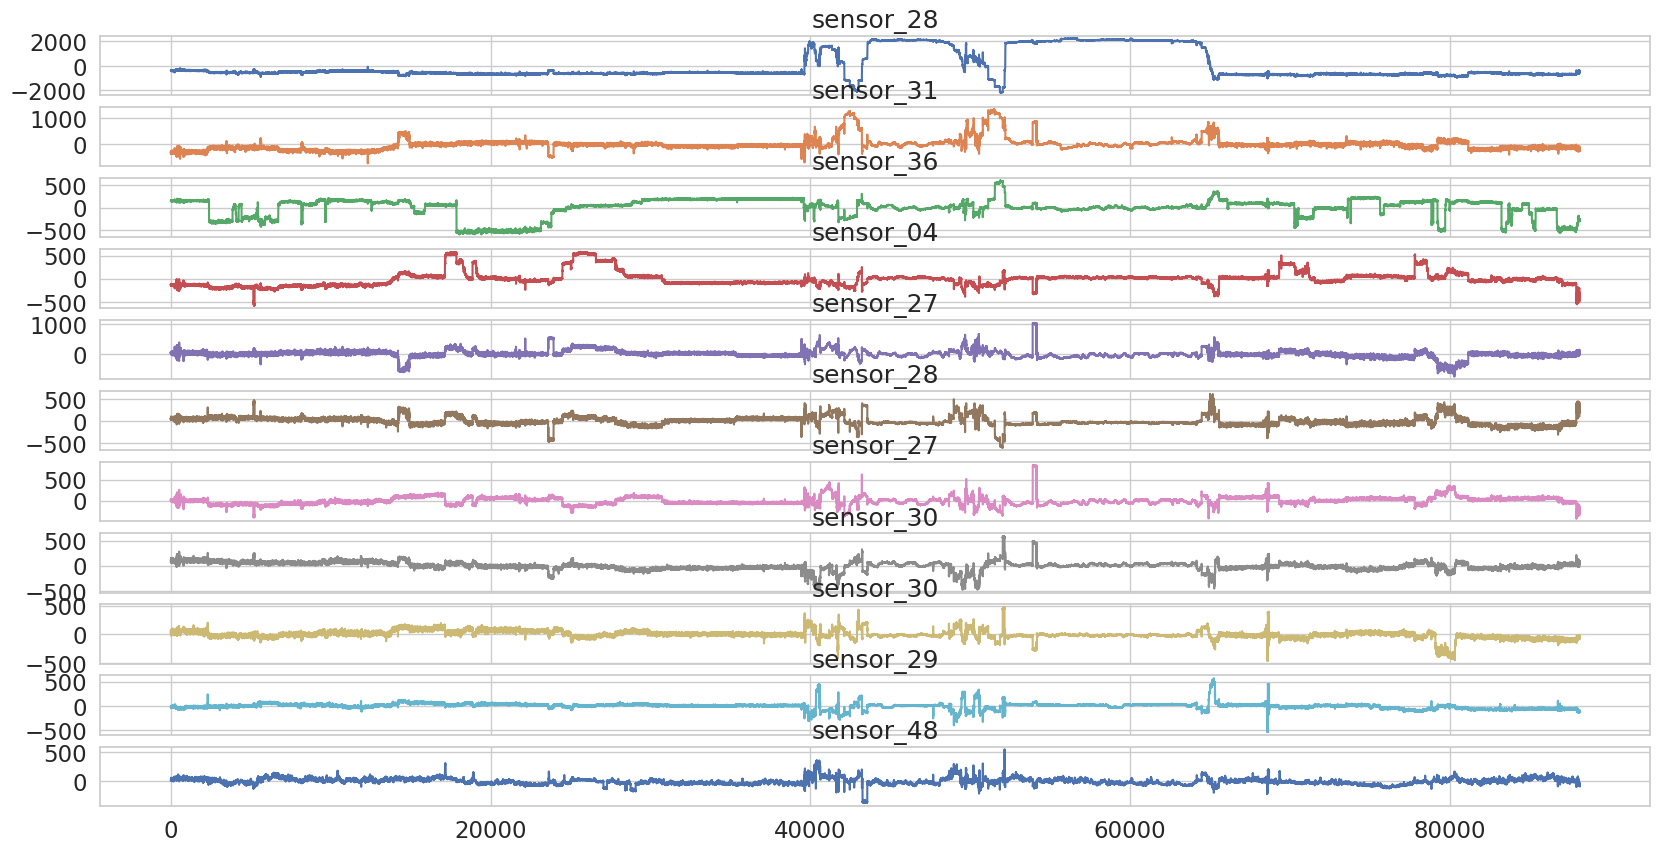

In [ ]:
# Crear un DataFrame a partir de reduced_X_train
df_reduced_X_train = pd.DataFrame(reduced_X_train)

# Graficar las características con subgráficos
df_reduced_X_train.plot(
    subplots=True,                # Crear subgráficos para cada columna
    sharex=True,                  # Compartir el eje x entre los subgráficos
    figsize=(20, 10),             # Tamaño de la figura
    title=most_important_sensors, # Títulos para cada subgráfico
    legend=False                  # Desactivar la leyenda
)

La covarianza indica en qué se diferencian las dos variables, mientras que la correlación muestra cómo se relacionan las dos variables.

A continuación, desarrollamos un Heatmap de correlación entre los sensores seleccionados.

##Heatmap de correlación

1. **Qué es:** Muestra cómo se relacionan entre sí dos o más variables. La correlación mide la relación lineal entre variables, indicando si un cambio en una variable está asociado con un cambio en otra.

2. **Valores:** Va de -1 a 1. Un valor cercano a 1 indica una relación positiva fuerte (a medida que una variable aumenta, la otra también lo hace). Un valor cercano a -1 indica una relación negativa fuerte (a medida que una variable aumenta, la otra disminuye). Un valor cercano a 0 indica poca o ninguna relación lineal.

3. Cómo leerlo:

- **Colores:** En el mapa de calor, los colores más intensos (dependiendo de la paleta) indican relaciones fuertes, ya sea positivas o negativas.
- **Intersecciones:** La intersección entre las filas y columnas muestra la correlación entre las variables correspondientes.




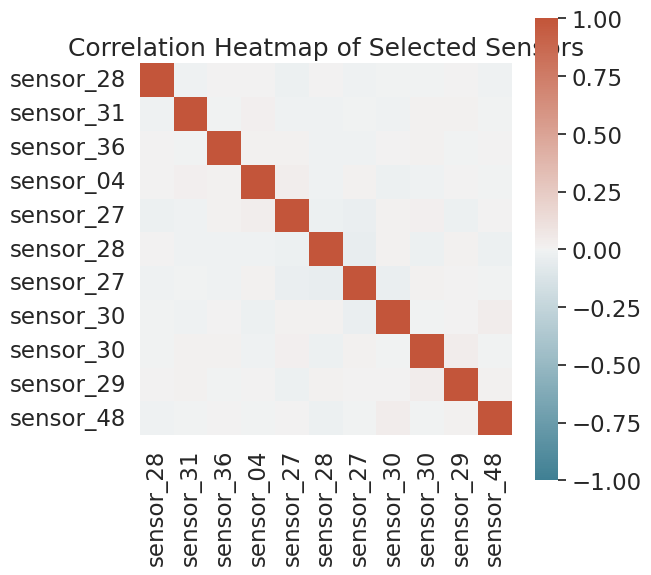

In [ ]:
# Configuración de la figura
plt.figure(figsize=(6, 6))

# Crear una paleta de colores para el mapa de calor
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Crear un DataFrame a partir de reduced_X_train y calcular la matriz de correlación
df_reduced_X_train = pd.DataFrame(reduced_X_train).sample(n=10000, replace=True, random_state=RANDOMSTATE)
corr_matrix = df_reduced_X_train.corr()

# Graficar el mapa de calor
sns.heatmap(
    corr_matrix,                  # Matriz de correlación
    square=True,                  # Hacer el mapa de calor cuadrado
    cmap=cmap,                    # Paleta de colores
    vmin=-1, vmax=1,              # Rango de valores para la paleta de colores
    yticklabels=most_important_sensors,  # Etiquetas de los ejes y
    xticklabels=most_important_sensors   # Etiquetas de los ejes x
)

# Agregar título al gráfico
plt.title('Correlation Heatmap of Selected Sensors')
plt.show()

Todos los sensores tienen un comportamiento diferente entre si, por lo que hay poca redundancia de información.

Aplicamos el mismo procedimiento para el Heatmap de Varianza

##Heatmap de varianza

1.**Qué es:** Muestra la variabilidad de una sola variable o de cada variable en un conjunto de datos. La varianza mide cuánto se dispersan los datos alrededor de su media.

2. **Valores:** La varianza es siempre positiva y puede ser cualquier valor. Una varianza alta indica que los datos están muy dispersos, mientras que una varianza baja indica que los datos están agrupados cerca de la media.

3. **Cómo leerlo:**
- **Colores:** Los colores en el mapa de calor muestran la magnitud de la varianza. Colores más intensos (dependiendo de la paleta) indican mayor varianza.
- **Intersecciones:** Si estás viendo la varianza de cada variable en diferentes momentos o condiciones, las intersecciones pueden mostrar cómo cambia la dispersión de datos.

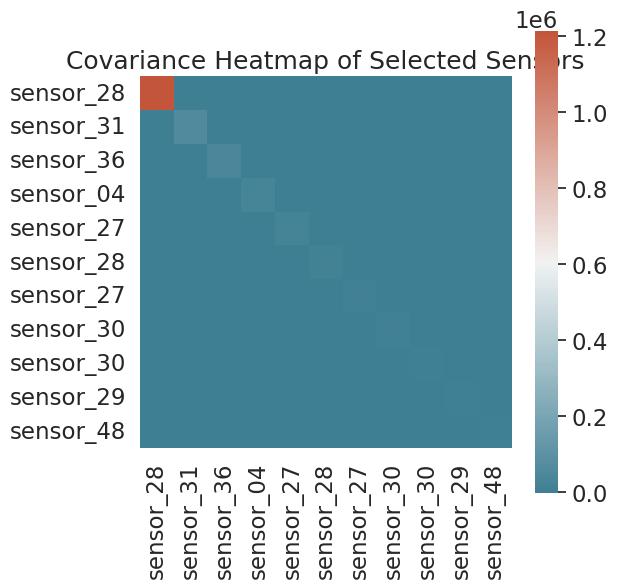

In [ ]:
# Configuración de la figura
plt.figure(figsize=(6, 6))

# Crear una paleta de colores para el mapa de calor
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Crear un DataFrame a partir de reduced_X_train y calcular la matriz de covarianza
df_reduced_X_train = pd.DataFrame(reduced_X_train).sample(n=10000, replace=True, random_state=RANDOMSTATE)
cov_matrix = df_reduced_X_train.cov()

# Graficar el mapa de calor de covarianza
sns.heatmap(
    cov_matrix,                  # Matriz de covarianza
    square=True,                 # Hacer el mapa de calor cuadrado
    cmap=cmap,                   # Paleta de colores
    vmin=cov_matrix.min().min(), # Rango mínimo de valores para la paleta de colores
    vmax=cov_matrix.max().max(), # Rango máximo de valores para la paleta de colores
    yticklabels=most_important_sensors,  # Etiquetas de los ejes y
    xticklabels=most_important_sensors   # Etiquetas de los ejes x
)

# Agregar título al gráfico
plt.title('Covariance Heatmap of Selected Sensors')
plt.show()

#8. Modelado

El objetivo de este caso en analizar la performance de diversos algoritmos de ML comúnmente en mantenimiento predictivo. De igual manero pueden implementarse otras técnicas particulares o algoritmos de Deep Learning.

Importamos librarias para modelado

In [ ]:
from sklearn.feature_selection import SelectKBest , chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

In [ ]:
df = pd.read_csv('sensor.csv')
df['timestamp']=pd.to_datetime(df['timestamp'])

Obteniendo el mes, dia, hour y minuto de datetime

In [ ]:
df['month']=df['timestamp'].dt.month
df['day']=df['timestamp'].dt.day
df['hour']=df['timestamp'].dt.hour
df['minute']=df['timestamp'].dt.minute

Con base en nuestro análisis anterior filtramos las columnas

In [ ]:
# List of columns to filter
columns_to_filter = [
    'sensor_28', 'sensor_31', 'sensor_36', 'sensor_04',
    'sensor_27', 'sensor_28', 'sensor_27', 'sensor_30',
    'sensor_30', 'sensor_29', 'sensor_48',
    'minute', 'day', 'hour', 'month', 'machine_status'
]

df = df[columns_to_filter]
# Remove duplicate columns
df = df.loc[:, ~df.columns.duplicated()]

In [ ]:
df.head()

,sensor_28,sensor_31,sensor_36,sensor_04,sensor_27,sensor_30,sensor_29,sensor_48,minute,day,hour,month,machine_status
0,785.1935,682.8125,195.0655,634.3750,429.0377,594.4445,684.9443,157.9861,0,1,0,4,NORMAL
1,785.1935,682.8125,195.0655,634.3750,429.0377,594.4445,684.9443,157.9861,1,1,0,4,NORMAL
2,778.5734,721.8750,200.9694,638.8889,454.2390,661.5740,715.6266,155.9606,2,1,0,4,NORMAL
3,779.5091,754.6875,193.1689,628.1250,474.8731,686.1111,690.4011,155.9606,3,1,0,4,NORMAL
4,785.2307,766.1458,193.8770,636.4583,408.8159,631.4814,704.6937,158.2755,4,1,0,4,NORMAL


filling the empty values based on the forward values

In [ ]:
df=df.fillna(method='ffill')

separating the output from the input features

In [ ]:
y=df['machine_status']
x=df.drop(['machine_status'],axis=1)

Normalization of the input features

In [ ]:
for i in x.columns:
    x[i]=(x[i]-np.min(x[i]))/(np.max(x[i])-np.min(x[i]))
x.describe()

,sensor_28,sensor_31,sensor_36,sensor_04,sensor_27,sensor_30,sensor_29,sensor_48,minute,day,hour,month
count,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000
mean,0.461324,0.472605,0.601712,0.737412,0.250752,0.383772,0.392604,0.232684,0.500000,0.493464,0.500000,0.503268
std,0.170442,0.159648,0.294757,0.180685,0.084909,0.122711,0.154144,0.153641,0.293528,0.294517,0.300965,0.353539
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.423755,0.458944,0.291569,0.782515,0.224149,0.392361,0.353593,0.107568,0.250000,0.233333,0.250000,0.250000
50%,0.524249,0.503226,0.720511,0.790064,0.247233,0.418113,0.384957,0.208649,0.500000,0.500000,0.500000,0.500000
75%,0.566007,0.539003,0.850555,0.796307,0.268136,0.435764,0.507176,0.340000,0.750000,0.733333,0.750000,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
x.isnull().sum()

sensor_28    0
sensor_31    0
sensor_36    0
sensor_04    0
sensor_27    0
sensor_30    0
sensor_29    0
sensor_48    0
minute       0
day          0
hour         0
month        0
dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder
enc=LabelEncoder()
y=enc.fit_transform(y)

In [ ]:
x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=0.2,stratify=y)

In [ ]:
x_train.head()

,sensor_28,sensor_31,sensor_36,sensor_04,sensor_27,sensor_30,sensor_29,sensor_48,minute,day,hour,month
158415,0.523972,0.546334,0.849274,0.797033,0.263371,0.462095,0.354793,0.557297,0.254237,0.633333,0.000000,0.75
213160,0.436512,0.451613,0.692151,0.778159,0.301611,0.422743,0.341982,0.437297,0.677966,0.866667,0.000000,1.00
204119,0.404671,0.468035,0.866304,0.801679,0.256337,0.434607,0.385327,0.603243,1.000000,0.633333,0.739130,1.00
76501,0.624768,0.601467,0.346745,0.784112,0.246610,0.432292,0.507036,0.060000,0.016949,0.766667,0.130435,0.25
191236,0.411706,0.563930,0.813448,0.801243,0.297211,0.479167,0.390410,0.447567,0.271186,0.333333,0.826087,1.00


##Model 1: Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model1=DecisionTreeClassifier()
model1.fit(x_train,y_train)

DecisionTreeClassifier()

accuracy 0.9997957516339869
precision 0.6660747672268923
recall 0.6662805221720265
Axes(0.125,0.11;0.62x0.77)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00     41170
           2       1.00      1.00      1.00      2893

    accuracy                           1.00     44064
   macro avg       0.67      0.67      0.67     44064
weighted avg       1.00      1.00      1.00     44064



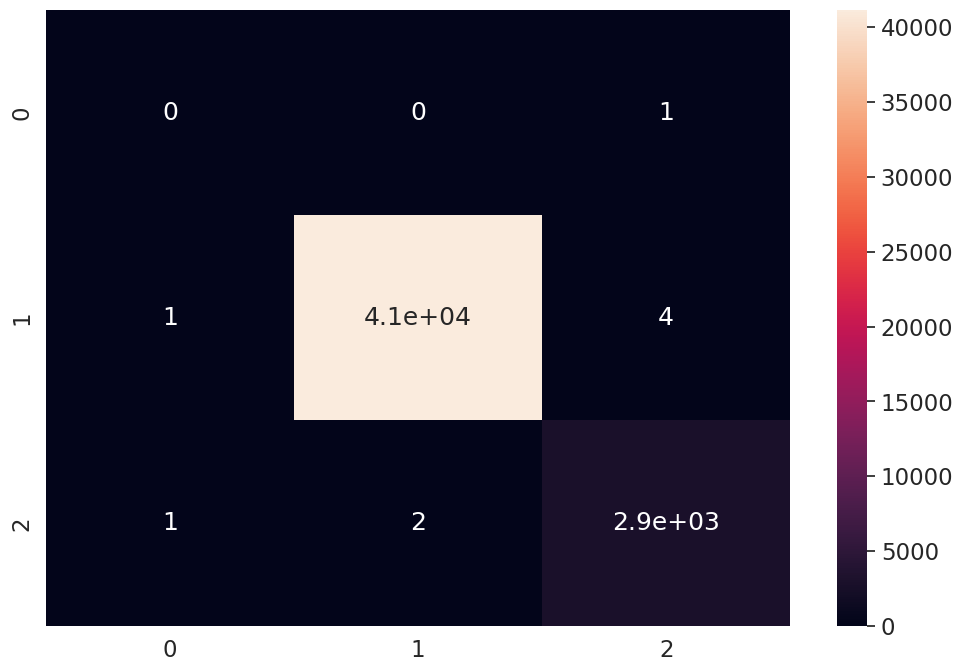

In [ ]:
o=model1.predict(x_test)
print('accuracy',accuracy_score(o,y_test))
print('precision',precision_score(o,y_test,average='macro'))
print('recall',recall_score(o,y_test,average='macro'))
print(sns.heatmap(confusion_matrix(o,y_test),annot=True))
print(classification_report(o,y_test))

##Model 2: Xtreme Boosting Classifier

In [ ]:
from xgboost import XGBClassifier
model2=XGBClassifier()
model2.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

accuracy 0.9998638344226579
precision 0.6663131464228877
recall 0.6662969534021084
Axes(0.125,0.11;0.62x0.77)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00     41169
           2       1.00      1.00      1.00      2895

    accuracy                           1.00     44064
   macro avg       0.67      0.67      0.67     44064
weighted avg       1.00      1.00      1.00     44064



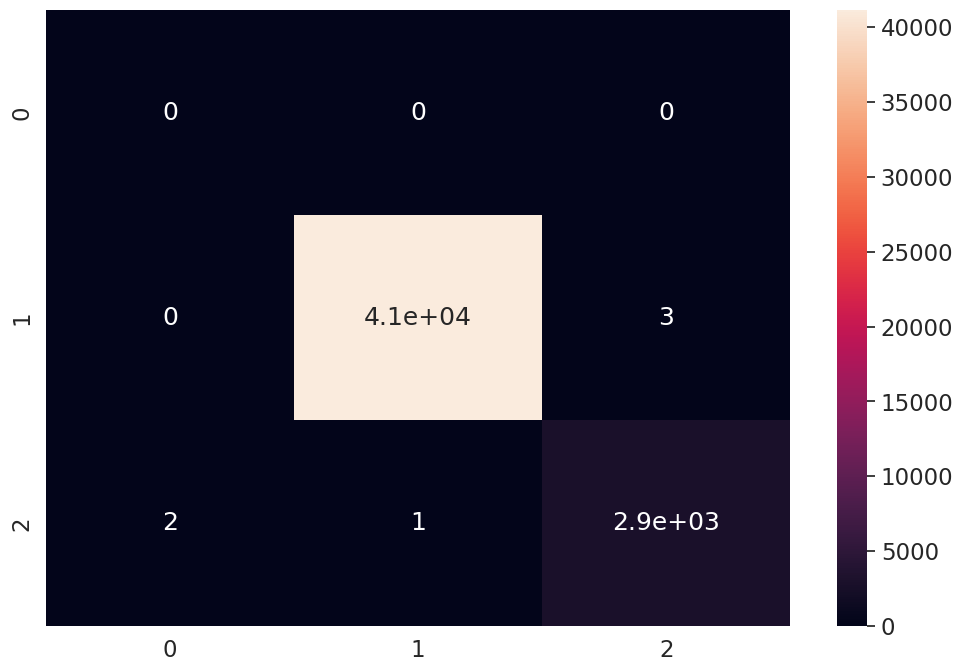

In [ ]:
o=model2.predict(x_test)
print('accuracy',accuracy_score(o,y_test))
print('precision',precision_score(o,y_test,average='macro'))
print('recall',recall_score(o,y_test,average='macro'))
print(sns.heatmap(confusion_matrix(o,y_test),annot=True))
print(classification_report(o,y_test))

In [ ]:
df['machine_status']=enc.fit_transform(df['machine_status'])

#Handling the issue of class imbalance by oversampling and undersampling relevant classes

In [ ]:
cls_0=df[df['machine_status']==0]
cls_1=df[df['machine_status']==1]
cls_2=df[df['machine_status']==2]
cls_0=cls_0.sample(15000,replace=True)
cls_1=cls_1.sample(15000,replace=True)
cls_2=cls_2.sample(15000,replace=True)
df=pd.concat([cls_0,cls_1,cls_2],axis=0)
df['machine_status'].value_counts()

machine_status
0    15000
1    15000
2    15000
Name: count, dtype: int64

In [ ]:
y=df['machine_status']
x=df.drop(['machine_status'],axis=1)

Normalization of input features

In [ ]:
for i in x.columns:
    x[i]=(x[i]-np.min(x[i]))/(np.max(x[i])-np.min(x[i]))
x.describe()

,sensor_28,sensor_31,sensor_36,sensor_04,sensor_27,sensor_30,sensor_29,sensor_48,minute,day,hour,month
count,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,0.520917,0.511176,0.540013,0.520663,0.245009,0.400221,0.411945,0.186541,0.448551,0.519144,0.449549,0.429556
std,0.152599,0.129506,0.254217,0.371388,0.081040,0.094949,0.139879,0.205167,0.306942,0.300839,0.345038,0.327929
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.533898,0.494818,0.300846,0.295012,0.238779,0.406286,0.356799,0.012181,0.186441,0.233333,0.130435,0.000000
50%,0.566470,0.529168,0.604026,0.402154,0.251298,0.420256,0.385764,0.129930,0.457627,0.566667,0.434783,0.500000
75%,0.614816,0.554634,0.816529,0.935281,0.270177,0.436554,0.527926,0.264501,0.694915,0.800000,0.782609,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#Model 3: Decision Tree Classifier with sampled data

In [ ]:
model3=DecisionTreeClassifier()
x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=0.2,stratify=y)
model3.fit(x_train,y_train)
y=enc.fit_transform(y)

accuracy 0.6831111111111111
precision 0.6831111111111111
recall 0.7867420219047028
Axes(0.125,0.11;0.62x0.77)
              precision    recall  f1-score   support

           0       0.14      1.00      0.25       420
           1       1.00      0.60      0.75      4977
           2       0.91      0.76      0.83      3603

    accuracy                           0.68      9000
   macro avg       0.68      0.79      0.61      9000
weighted avg       0.92      0.68      0.76      9000



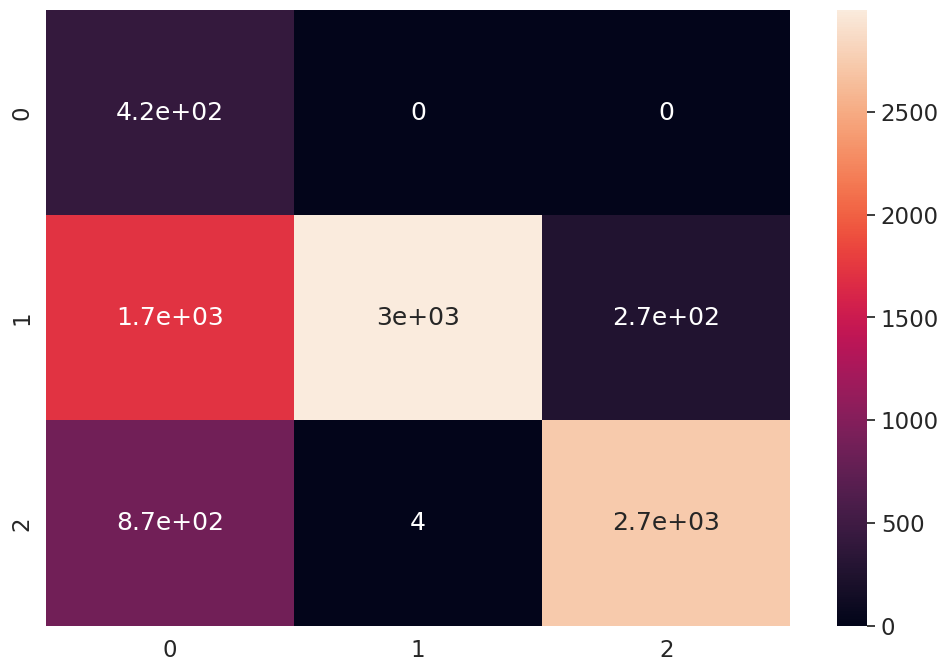

In [ ]:
o=model1.predict(x_test)
print('accuracy',accuracy_score(o,y_test))
print('precision',precision_score(o,y_test,average='macro'))
print('recall',recall_score(o,y_test,average='macro'))
print(sns.heatmap(confusion_matrix(o,y_test),annot=True))
print(classification_report(o,y_test))